## Libraries

In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [3]:
# tf.__version__

In [4]:
import sys
sys.path.insert(0, '../.')

In [5]:
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
from Trainer import *
from evaluation.evaluate import *

In [6]:
tf.__version__

'1.14.0'

In [7]:
from data.postprocessing.nms import *

In [8]:
# params = {
#     'fusion': False
# }
# model = Model(graph=None, **params)

In [9]:
# model.cnn.res_groups

In [10]:
# model.cnn_lidar.res_groups

In [11]:
# with model.graph.as_default():
#     fusion_only_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
#                                             "fusion")

In [12]:
# fuse_ops = tf.train.AdamOptimizer(1e-3).minimize(model.model_loss, var_list=fusion_only_vars, global_step=model.global_step)

In [13]:
# fusion_only_vars

In [14]:
# !cat ~/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py 

In [15]:
# params = {
#     'fusion': True
# }
# model = Model(graph=None, **params)

## Utils

In [16]:
def prepare_dataset_feed_dict(model, dataset, train_fusion_rgb, train_fusion_fv_lidar, anchor_values, use_nms, is_training=False):
        # camera_tensor, lidar_tensor, fv_velo_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = sess.run(dataset)
        data = list(dataset.get_next(batch_size=1))
#         data = list(next(dataset))

#         for i in range(len(data)):
#             data[i] = np.expand_dims(data[i], axis=0)
        camera_tensor, lidar_tensor, label_tensor, label_up_tensor, label_down_tensor, label_left_tensor, label_right_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = data
#         print(np.max(camera_tensor))
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.y_true_up: label_up_tensor,
                model.y_true_down: label_down_tensor,
                model.y_true_left: label_left_tensor,
                model.y_true_right: label_right_tensor,
                model.Tr_velo_to_cam: Tr_velo_to_cam,
                model.R0_rect: R0_rect,
                model.P3: P3,
                model.shift_h: shift_h,
                model.shift_w: shift_w,
                model.anchors: anchor_values,
                model.use_nms: use_nms,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: is_training}
        return d

In [17]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(512, 448), output_size=(128, 112), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, :, -1]>=th)
#     print(ones_index)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
#             if not is_label:
#               out[:3] = sigmoid(out[:3])
#             if not is_label:
#                 out[:3] = 2 * sigmoid(out[:3]) - 1
            out[:3] = np.tanh(out[:3])*0.5 * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 40
            
            out[3:6] = np.square(np.maximum(0, out[3:6])) * anchors
            
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [18]:
import numpy as np
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm

def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add third point
    #x3, y3 = bbox[0][4], bbox[1][4]   
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]

In [19]:
def get_points(converted_points, calib_path, 
                x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                size=(512, 448, 40), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            # x_range=(0, 70)
            # y_range=(-40, 40)
            # z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

## Model

In [20]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).



/home/injy/mariam_workspace/env/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





## Evaluation

In [21]:
from tensorflow.python.framework.ops import get_gradient_function

a = tf.add(1, 2, name="Add_these_numbers")
b = tf.multiply(a, 3, name='mult')
c = tf.reduce_sum(a, name='s')

mult = tf.get_default_graph().get_operation_by_name('s')
print(get_gradient_function(mult))  # <function _MulGrad at 0x7fa29950dc80>

g = tf.greater_equal(a, 3, name='ge1')
stop = tf.get_default_graph().get_operation_by_name('ge1')
print(get_gradient_function(stop))  # None

<function _SumGrad at 0x7f542b30b840>
None


In [22]:
# dataset = DetectionDatasetLoader(base_path='../../../Data', batch_size=4, random_seed=0, training=True)
# temp = dataset.get_next(batch_size=4)

In [23]:
# temp = dataset.get_next(batch_size=4)

In [24]:
# temp[0].shape

In [25]:
# np.max(temp[1])

In [26]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']




In [27]:
# del temp

In [28]:
# "1", 5, 6 more, 

In [29]:
base_path = '../../../Data'

In [30]:
def data_generator(base_path, i, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                   image_size=(370, 1224), lidar_size=(512, 448, 40), anchors=np.array([3.9, 1.6, 1.5]),
                        augment_translate=False, augment_rotate=False):


                camera_path = list_camera_paths[i]
                lidar_path = list_lidar_paths[i]
                label_path = list_label_paths[i]
                calib_path = list_calib_paths[i]
#             for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
                camera_image, shift_h, shift_w = read_camera(camera_path, image_size)
                lidar_image = read_lidar(lidar_path, calib_path, lidar_size)
                velo_front_view = read_pc_fv(calib_path, lidar_path)
                _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(label_path, calib_path, shift_h, shift_w)
               
                label = get_target(label, directions, anchors=anchors)
                camera_image = camera_image / 255.
                lidar_image = lidar_image / 255.
                yield(camera_image, lidar_image, label, 
                            np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                            np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                            np.array(P3).reshape((3, 4)), 
                            np.array([shift_h]), 
                            np.array([shift_w])
                            )

In [31]:
# area_overlap_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), area_overlap, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# area_g_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), area_g, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# area_d_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), area_d, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))


# h_overlap_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), h_overlap, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# h_d_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), h_d, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# h_g_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), h_d, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# x1_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x1, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# x2_1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x2, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))


# x1__1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x1_, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))

# x2__1 = tf.where(tf.greater_equal(feed_dict[model.y_true][:, :, :, :, 8],0.5), x2_, tf.zeros_like(feed_dict[model.y_true][:, :, :, :, 8]))


# with tf.Session(config=config) as sess:
#     t = np.where(feed_dict[model.y_true][:, :, :, :, 8]>0.5)
#     i = 0
#     t1 = sess.run(area_overlap_1[t[0][i], t[1][i], t[2][i], t[3][i]])
#     print(t1)
#     t2 = sess.run((area_g_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t2)
#     t3 = sess.run((area_d_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t3)
#     t4 = sess.run((h_overlap_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t4)
#     t5 = sess.run((h_g_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t5)
#     t6 = sess.run((h_d_1[t[0][i], t[1][i], t[2][i], t[3][i]]))
#     print(t6)
#     print('x1', sess.run((x1_1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('x2', sess.run((x2_1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('x1_', sess.run((x1__1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('x2_', sess.run((x2__1[t[0][i], t[1][i], t[2][i], t[3][i]])))
#     print('2d iou : ', (t1)/(t2+t3-t1))
#     print('iou = ', (t1*t4)/(t2*t5+t6*t3-t1*t4))
#     print(sess.run(tf.math.count_nonzero(feed_dict[model.y_true][:, :, :, :, 8])))
#     print('___________________')
#     anchors_size=np.array([3.9, 1.6, 1.5])
#     print(sess.run(tf.math.exp(final_output[:, :, :, :, 3:6])*anchors_size)[t[0][i], t[1][i], t[2][i], t[3][i]])
#     print(sess.run(tf.math.exp(feed_dict[model.y_true][:, :, :, :, 3:6])*anchors_size)[t[0][i], t[1][i], t[2][i], t[3][i]])
#     print(final_output[t[0][i], t[1][i], t[2][i], t[3][i], 0]*anchors_size[0] + 0.5)
#     print(feed_dict[model.y_true][t[0][i], t[1][i], t[2][i], t[3][i], 0]*anchors_size[0] + 0.5)

In [32]:
def prepare_dataset_feed_dict_2(model, dataset, train_fusion_rgb, train_fusion_fv_lidar, anchor_values, use_nms, is_training=False):
        # camera_tensor, lidar_tensor, fv_velo_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = sess.run(dataset)
#         data = list(dataset.get_next(batch_size=1))
        data = list(next(dataset))

        for i in range(len(data)):
            data[i] = np.expand_dims(data[i], axis=0)
#             print(data[i].shape)
        camera_tensor, lidar_tensor, label_tensor , Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = data
#         print(np.max(camera_tensor))
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.Tr_velo_to_cam: Tr_velo_to_cam,
                model.R0_rect: R0_rect,
                model.P3: P3,
                model.shift_h: shift_h,
                model.shift_w: shift_w,
                model.anchors: anchor_values,
                model.use_nms: use_nms,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: is_training}
        return d

In [33]:
training=False

In [34]:
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)

camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
ln = int(len(list_files) * 0.5)
final_sample = len(list_files)
        
if training:
            list_files = list_files[:ln]
            list_camera_paths = camera_paths[:ln]
            list_lidar_paths = lidar_paths[:ln]
            list_label_paths = label_paths[:ln]
            list_calib_paths = calib_paths[:ln]
else:
            list_camera_paths = camera_paths[ln:final_sample]
            list_lidar_paths = lidar_paths[ln:final_sample]
            list_label_paths = label_paths[ln:final_sample]
            list_calib_paths = calib_paths[ln:final_sample]
            list_files = list_files[ln:final_sample]


In [35]:
len(list_files)*0.2 //4

187.0

In [36]:
list_files2 = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files2)
ln = int(len(list_files2) * 0.5)
list_files2= list_files2[ln:]

In [37]:
ln

3740

In [38]:
# list_files.index('001966')

In [39]:
i_c = 33
current_file = list_files2[i_c]
current_file

'003216'

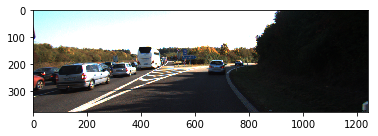

In [40]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [77]:
with model.graph.as_default():
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     sess.run(tf.global_variables_initializer())
    anchor_values = prepare_anchors()
#     print(anchor_values.shape)
#     anchor_values = np.repeat(anchor_values, 1, axis=0)
    anchor_values = np.repeat(anchor_values, 1, axis=0)
#     dataset = DetectionDatasetLoader(base_path='../../../Data', batch_size=1, random_seed=0, training=False)
    dataset = data_generator(base_path, i_c, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths)
   
    i = 0
    while i <= i_c:
#       i += 1
      feed_dict = prepare_dataset_feed_dict_2(model, dataset, False, False, anchor_values, False)
#       if i <= i_c:
#         continue
#       print(i)
#       final_output, loss, classification_loss, regression_loss, \
#             debug_layers, detection_layer = sess.run([model.final_output, model.model_loss, 
#                                                                 model.classification_loss, model.regression_loss, 
#                                                                        model.debug_layers, model.detection_layer], 
#                                                 feed_dict=feed_dict)
#       feed_dict[model.learning_rate_placeholder] = 0.001
      final_output, debug_layers, res_groups, cls_loss, loc_loss, dim_loss, theta_loss,\
            iou, iou_dim, iou_loc, cls_weight, dim_weight, loc_weight, theta_weight,\
            precision, recall = sess.run([model.final_output, model.debug_layers,\
                                                            model.cnn_lidar.res_groups,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                              model.iou, model.iou_dim, model.iou_loc,\
                                                              model.cls_weight, model.dim_weight, model.loc_weight, model.theta_weight,\
                                                             model.precision, model.recall],\
                                                             feed_dict=feed_dict)   
    
      break 
    

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-200


In [78]:
iou, iou_dim, iou_loc

(0.46286365, 0.6788635, 0.48270088)

In [79]:
precision, recall

(1.9864317, 1.9739944)

In [80]:
cls_weight, dim_weight, loc_weight, theta_weight

(1.0, 1.0, 1.0, 0.8000026)

In [81]:
cls_loss, loc_loss, dim_loss, theta_loss

(7.712885, 0.081539385, 0.015266234, 0.04165738)

In [82]:
iou, iou_dim, iou_loc

(0.46286365, 0.6788635, 0.48270088)

In [83]:
precision, recall

(1.9864317, 1.9739944)

In [84]:
cls_weight, dim_weight, loc_weight, theta_weight

(1.0, 1.0, 1.0, 0.8000026)

In [85]:
cls_loss, loc_loss, dim_loss, theta_loss

(7.712885, 0.081539385, 0.015266234, 0.04165738)

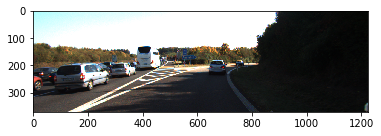

In [86]:
plt.imshow(feed_dict[model.train_inputs_rgb][0])

In [87]:
img.shape

(512, 448)

In [88]:

# current_file = list_files2[3]
    
translate_x = 0
translate_y = 0
translate_z = 0
ang = 0

# i_c = 25
# current_file = list_files2[i_c]
# current_file

h, w, _ = cv2.imread(base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png').shape
all_data, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True,
                                                         ang=ang, translate_x=translate_x,
                                              translate_y=translate_y, translate_z=translate_z)

lidar_image = velo_points_bev(base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin',
                              base_path + '/data_object_calib/training/calib/'+ current_file + '.txt',
                           size=(512, 448, 40), img_height=375, img_width=1242, ang=ang, translate_x=translate_x,
                              translate_y=translate_y, translate_z=translate_z)

# label = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

In [89]:
# t = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'
# !cat $t

In [90]:
# t2 = './' + current_file + '.txt'
# !cat $t2

In [91]:
len(label)

7

In [92]:
directions

array([0., 0., 0., 0., 0., 0., 0.])

<Figure size 432x288 with 0 Axes>

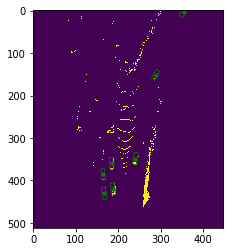

In [93]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
ax.imshow(img)


for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

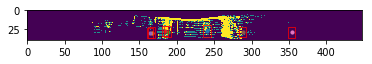

In [94]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    h = label[i][5]
    l = label[i][3] 
    w = label[i][4]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

plt.show()


In [95]:
def plot_point(point, angle, length):
     '''
     point - Tuple (x, y)
     angle - Angle you want your end point at in degrees.
     length - Length of the line you want to plot.

     Will plot the line on a 10 x 10 plot.
     '''

     # unpack the first point
     x, y = point

     # find the end point
     endy = length * math.sin(math.radians(angle))
     endx = length * math.cos(math.radians(angle))

     # plot the points
     fig = plt.figure()
     ax = plt.subplot(111)
     ax.set_ylim([0, 10])   # set the bounds to be 10, 10
     ax.set_xlim([0, 10])
     ax.plot([x, endx], [y, endy])

     fig.show()

<Figure size 432x288 with 0 Axes>

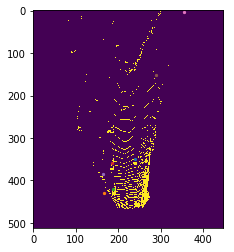

In [96]:



plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, :], 2), 0, 1)
ax.imshow(img)

boxes = []

for j in range(0, len(label)):

    w = label[j][5]
    h = label[j][4] 
    x = label[j][0]
    y = label[j][1]
    a = label[j][6]
    if a < 0:
          a = a + 3.14
    
    plt.scatter(y, x, s=5)

    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])
        
    boxes.append([xs[0], ys[0], xs[2], ys[2]])
    
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
    

    
        
plt.show()

<Figure size 432x288 with 0 Axes>

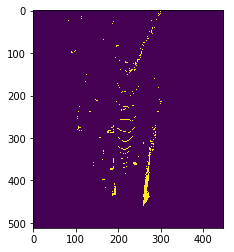

In [97]:
plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(feed_dict[model.train_inputs_lidar][0][:, :, 13:]*255, 2), 0, 1)
ax.imshow(img)     
plt.show()

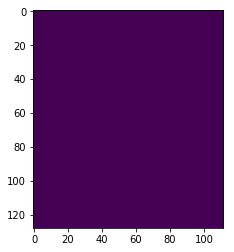

In [98]:
plt.imshow(feed_dict[model.y_true][0, :, :, 0, -1])
plt.show()

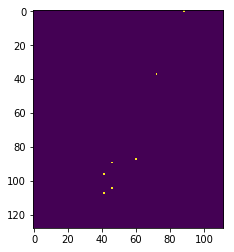

In [99]:
plt.imshow(feed_dict[model.y_true][0, :, :, 1, -1])
plt.show()

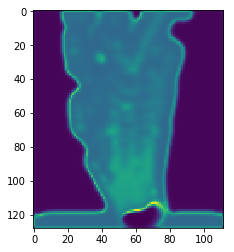

In [100]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1]))
plt.show()

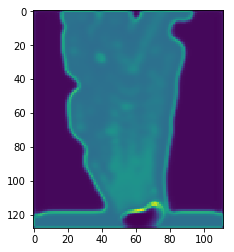

In [101]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1]))
plt.show()

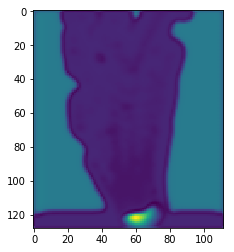

In [102]:
plt.imshow(1-final_output[0, :, :, 0, -1])
plt.show()

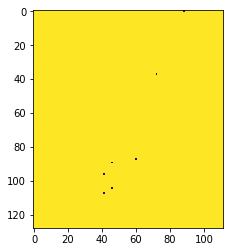

In [103]:
plt.imshow((sigmoid(final_output[0, :, :, 1, -1]) * (1-feed_dict[model.y_true][0, :, :, 1, -1]))>0)
plt.show()

In [69]:
c = (sigmoid(final_output[0, :, :, 1, -1]) * (1-feed_dict[model.y_true][0, :, :, 1, -1]))>0
np.sum(sigmoid(final_output[0, :, :, 1, -1])[c])

188.13083

In [70]:
128*112

14336

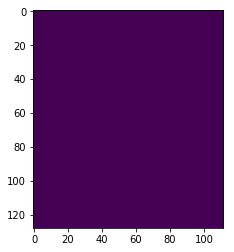

In [71]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1]) >= 0.5)
plt.show()

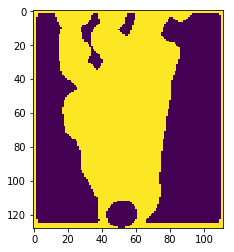

In [72]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1])>=0.01)
plt.show()

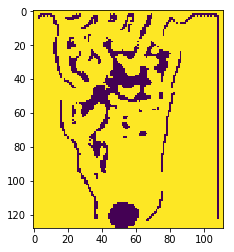

In [73]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1])>=0.01)
plt.show()

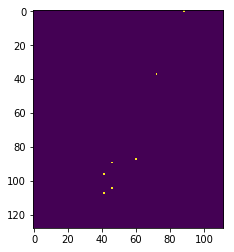

In [74]:
plt.imshow(sigmoid(feed_dict[model.y_true][0, :, :, 1, -1]))
plt.show()

In [75]:
np.max(sigmoid(final_output[0, :, :, 1, -1])), np.min(sigmoid(final_output[0, :, :, 1, -1]))

(0.057855625, 5.74778e-05)

In [76]:
np.max(sigmoid(final_output[0, :, :, 0, -1])), np.min(sigmoid(final_output[0, :, :, 0, -1]))

(0.09375775, 2.485037e-12)

In [149]:
np.min(final_output[0, :, :, :, -1]), np.max(final_output[0, :, :, :, -1])

(-5.9086285, 38.54892)

In [125]:
np.min(final_output[0, :, :, 0, -1]), np.max(final_output[0, :, :, 0, -1])

(-2.6739135, 4.963009)

In [126]:
np.min(final_output[0, :, :, 1, -1]), np.max(final_output[0, :, :, 1, -1])

(-2.157804, 61.843708)

In [127]:
np.max(sigmoid(final_output[0, :, :, :, -1])), np.min(sigmoid(final_output[0, :, :, :, -1]))

(1.0, 0.06453032)

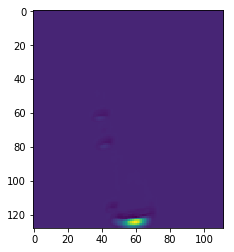

In [128]:
plt.imshow(final_output[0, :, :, 0, -1])
plt.show()

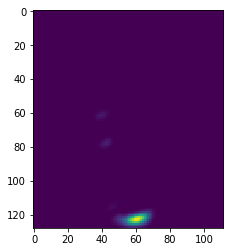

In [129]:
plt.imshow(final_output[0, :, :, 1, -1])
plt.show()

In [130]:
len(label)

3

In [85]:
t0 = np.where(sigmoid(feed_dict[model.y_true][0, :, :, 1, -1])>=0.7)
t0

(array([ 89,  92, 100]), array([56, 39, 44]))

In [86]:
len(t0[0])

3

In [87]:
t1 = np.where(sigmoid(final_output[0, :, :, 1, -1])>=0.4)
t1

(array([  0,   0,   0, ..., 127, 127, 127]),
 array([ 22,  23,  24, ..., 109, 110, 111]))

In [88]:
len(t1[0])

7939

In [89]:
i = 1
a = t0[0][i]
b = t0[1][i]

In [90]:
print(np.tanh(final_output[0, a, b, 1, :3])*0.5)
print(final_output[0, a, b, 1, 3:6])
print(sigmoid(final_output[0, a, b, 1, 6]) * np.pi/2 - np.pi/4)
print(sigmoid(final_output[0, a, b, 1, 7:]))

[-0.0246199  -0.00443775  0.12298993]
[1.16822   1.2434369 1.0680174]
-0.1830015486004788
[0.6036228 0.9856364]


In [91]:
print(feed_dict[model.y_true][0, a, b, 1, :3])
print(feed_dict[model.y_true][0, a, b, 1, 3:6])
print(feed_dict[model.y_true][0, a, b, 1, 6:])

[-0.00882678 -0.15583597  0.11579396]
[0.89155585 0.96824586 1.        ]
[-0.01079633  1.          1.        ]


In [92]:
v = np.tanh(final_output[0, a, b, 1, :3])*0.5 - feed_dict[model.y_true][0, a, b, 1, :3]
print(v)
# print(v*np.array([3.9, 1.6, 1.5]) * np.array([4, 4, 40]))

[-0.01579312  0.15139823  0.00719597]


In [201]:
# v = np.array([3.9, 1.6, 1.5]) * np.array([4, 4, 40])
# print(v)
# print(v/min(v))

In [202]:
v = np.maximum(0, final_output[0, a, b, 1, 3:6]) - feed_dict[model.y_true][0, a, b, 1, 3:6]
print(v)
print(np.square(v) * np.array([3.9, 1.6, 1.5]))
print(v / min(v))
print(np.array([3.9, 1.6, 1.5]) / 1.5)

[-0.08682382 -0.12719285 -0.18605411]
[0.02939967 0.02588484 0.0519242 ]
[0.46665898 0.6836337  1.        ]
[2.6        1.06666667 1.        ]


In [203]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
#     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
#                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
#                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
#                     get_neg=False):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
#     print(len(lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
#             print(len(lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print(len(locations))
    # print(z_range)
    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
#     print("indxes", len(indxes[indxes==True]))
#     print("indxes", indxes)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

#     print(len(locations))
    if len(locations) > 0:
        locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

    # print('.......')
    

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            # print(dimension_length[i])
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            # print(dimension_length[i])
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            # print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
            # print(dimension_height[i])

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = np.array(output)
    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
    else:
        return output, indxes




<Figure size 432x288 with 0 Axes>

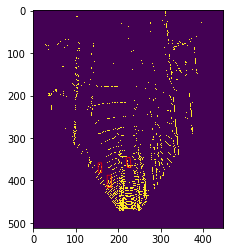

In [143]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)



plt.show()


In [144]:

from datetime import datetime



In [145]:
th=0.1
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])

print(np.array([points[i][-1] for i in range(len(points))]))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
        print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    print(y, x)
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


KeyboardInterrupt: 

In [ ]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
    print(y, z)
    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
    print(y, z)
    plt.scatter(y, z, s=10)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='b',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [ ]:
28.589532366799695 - 27.443132743480575

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

In [ ]:
len(label_bev)

In [302]:
label.shape

(16, 7)

<Figure size 432x288 with 0 Axes>

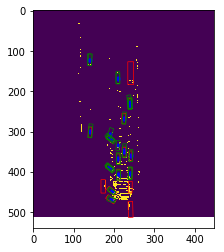

In [303]:
th=0.2
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    plt.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

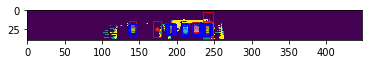

In [304]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]

    plt.scatter(y, z, s=10)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='b',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [305]:
len(label_bev)

38

22.940976438698943 9.333734927952506 81.93299400000001
22.30949565173634 8.38112812817617 89.381448
29.290930117601516 9.330608096397297 89.954406

9.437097366752823 6.268062948870807 81.81086227272
9.688108765263044 6.367115253787083 81.69442001838
9.722170141266973 6.408532027042381 81.39334204854



<Figure size 432x288 with 0 Axes>

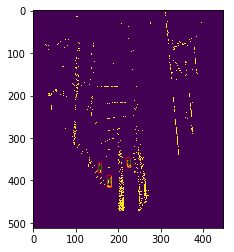

In [205]:
th=0.01
truth_value = feed_dict[model.y_true][0, :, :, :, :]
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    print(w, h, a*57.2958)
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][5] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
#     plt.scatter(y, x, s=10, c='b')
    print(w, h, label_bev[i][6]*57.2958)
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

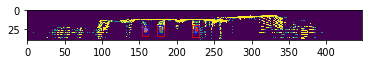

In [206]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]

    plt.scatter(y, z, s=10)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='b',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


<Figure size 432x288 with 0 Axes>

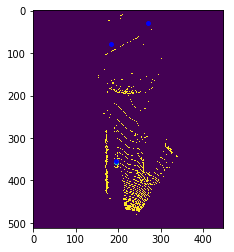

In [419]:
th=0.15
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
    if a < 0:
      a = a + 3.14

    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][5] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
#     print(x, y)
    plt.scatter(y, x, s=15, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)

print()


plt.show()


In [80]:
# t = './' + current_file + '.txt'
# !cat $t

<Figure size 432x288 with 0 Axes>

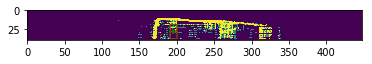

In [423]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10, c='r')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    

for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
    
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10, c='g')
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    break
    
plt.show()


In [82]:
random.random() - 0.5

0.1123364506493657

In [84]:
debug_layers['fpn_lidar'][1].shape

(1, 128, 112, 64)

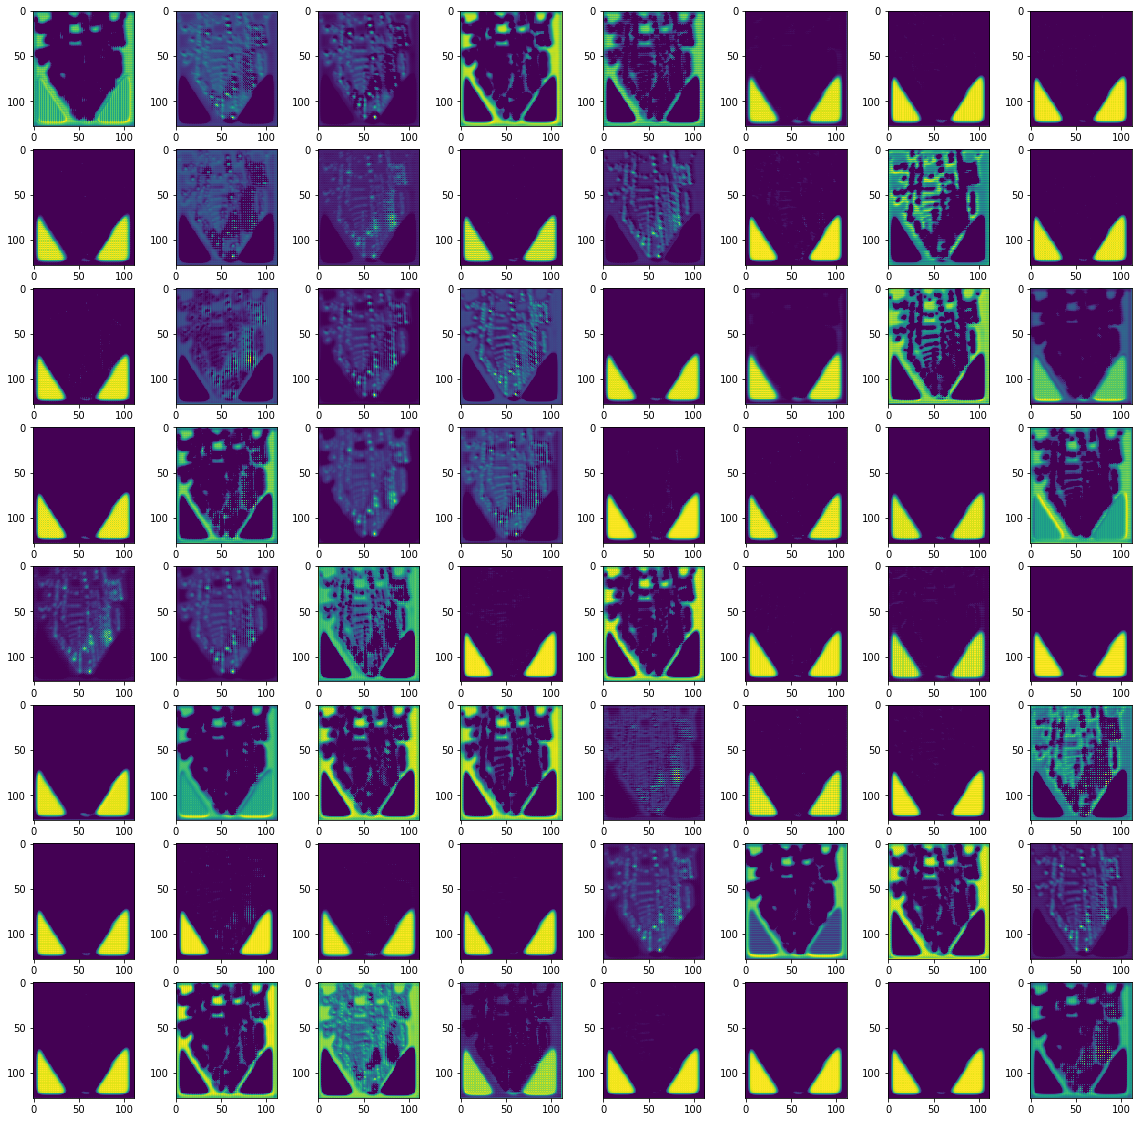

In [146]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar_output_post_conv_0'][0, :, :, c])
    c += 1
plt.show()

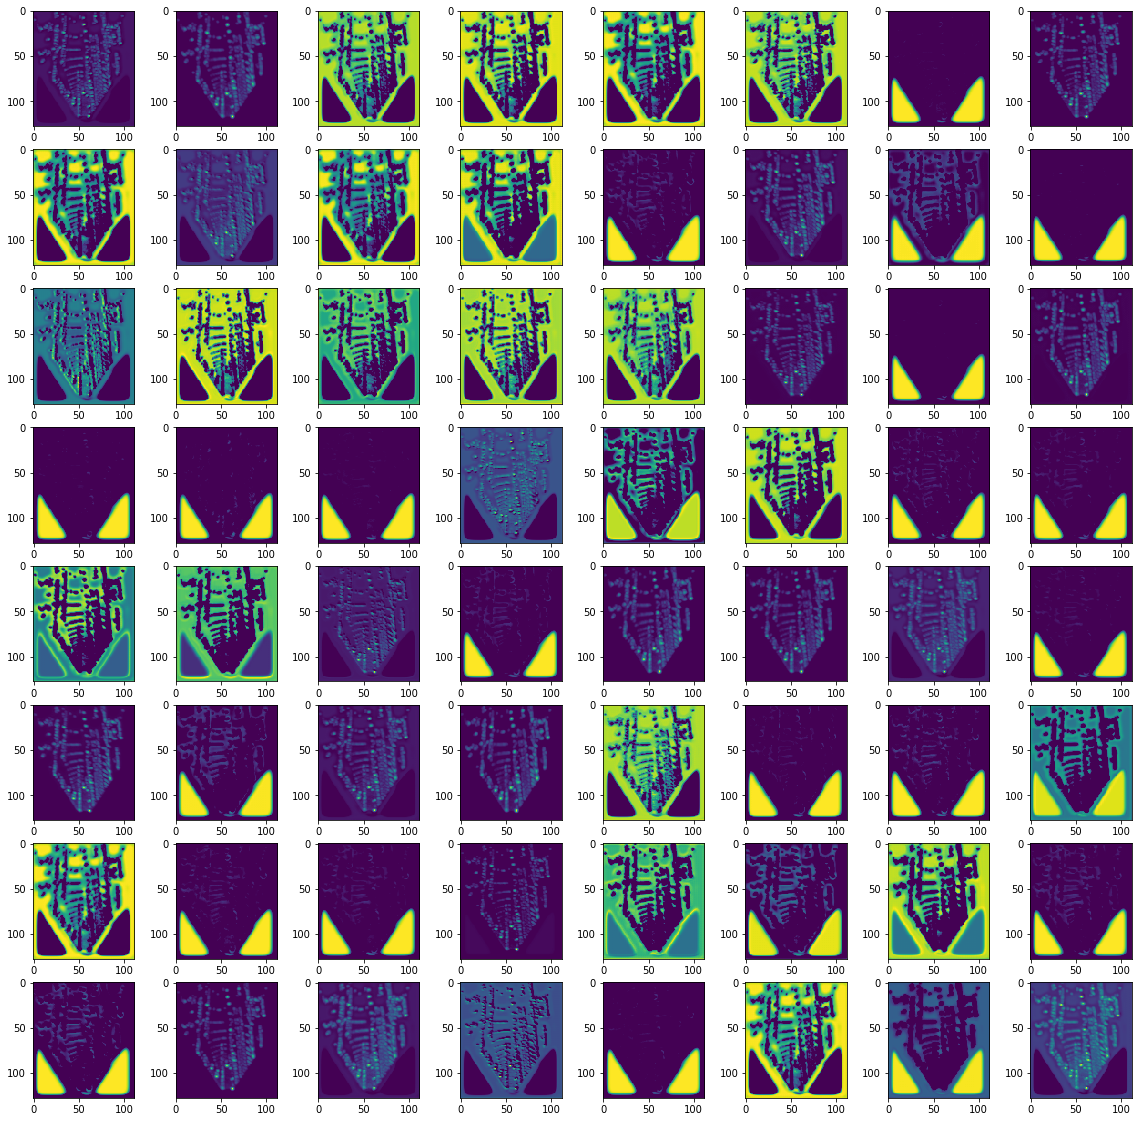

In [147]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar'][0][0, :, :, c])
    c += 1
plt.show()

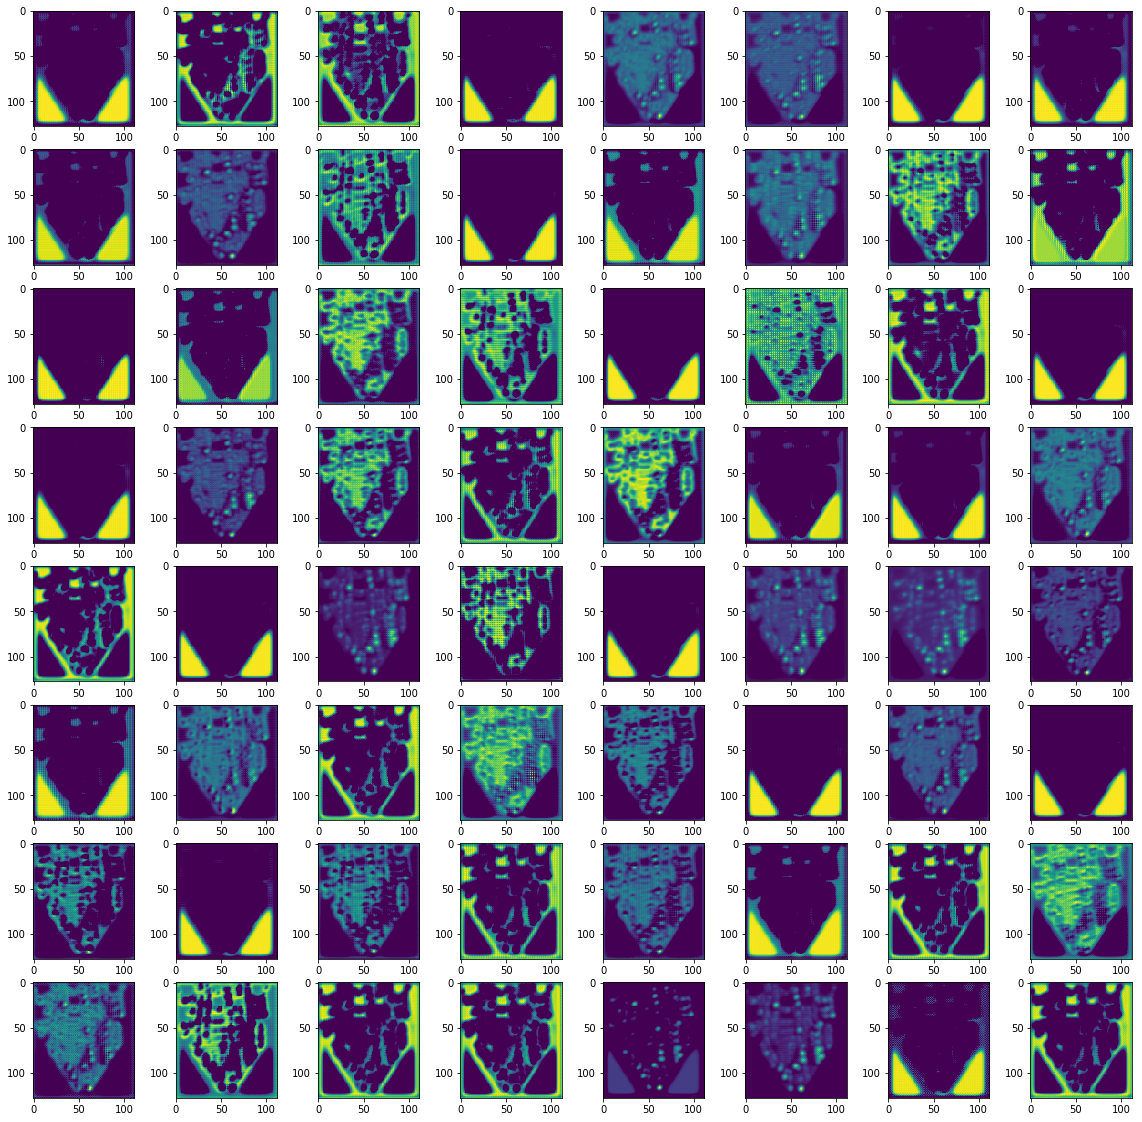

In [148]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar'][1][0, :, :, c])
    c += 1
plt.show()

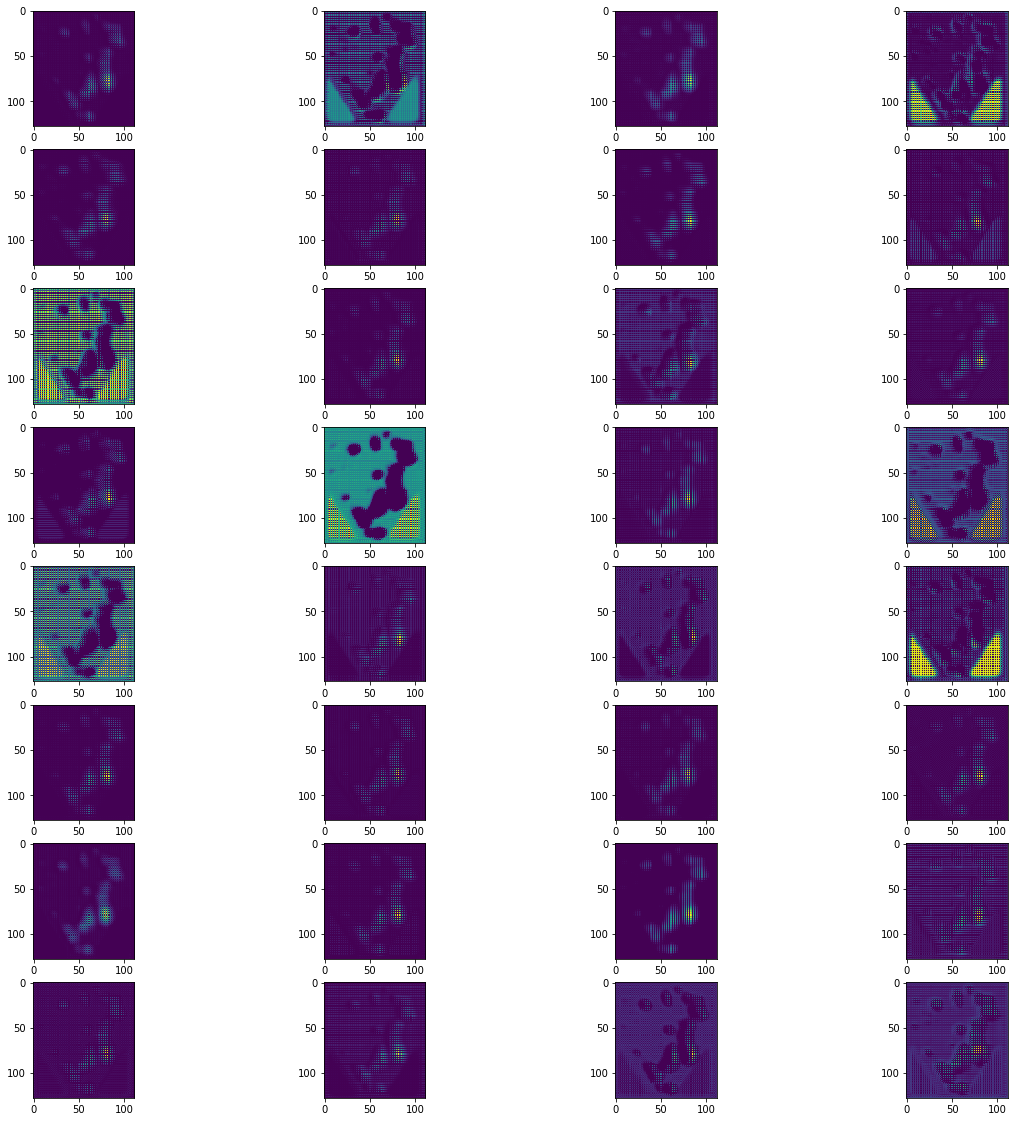

In [149]:
fig, axarr = plt.subplots(8, 4, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(4):
    plt.subplot(8, 4, c+1)
    plt.imshow(debug_layers['fpn_lidar'][2][0, :, :, c])
    c += 1
plt.show()

IndexError: list index out of range

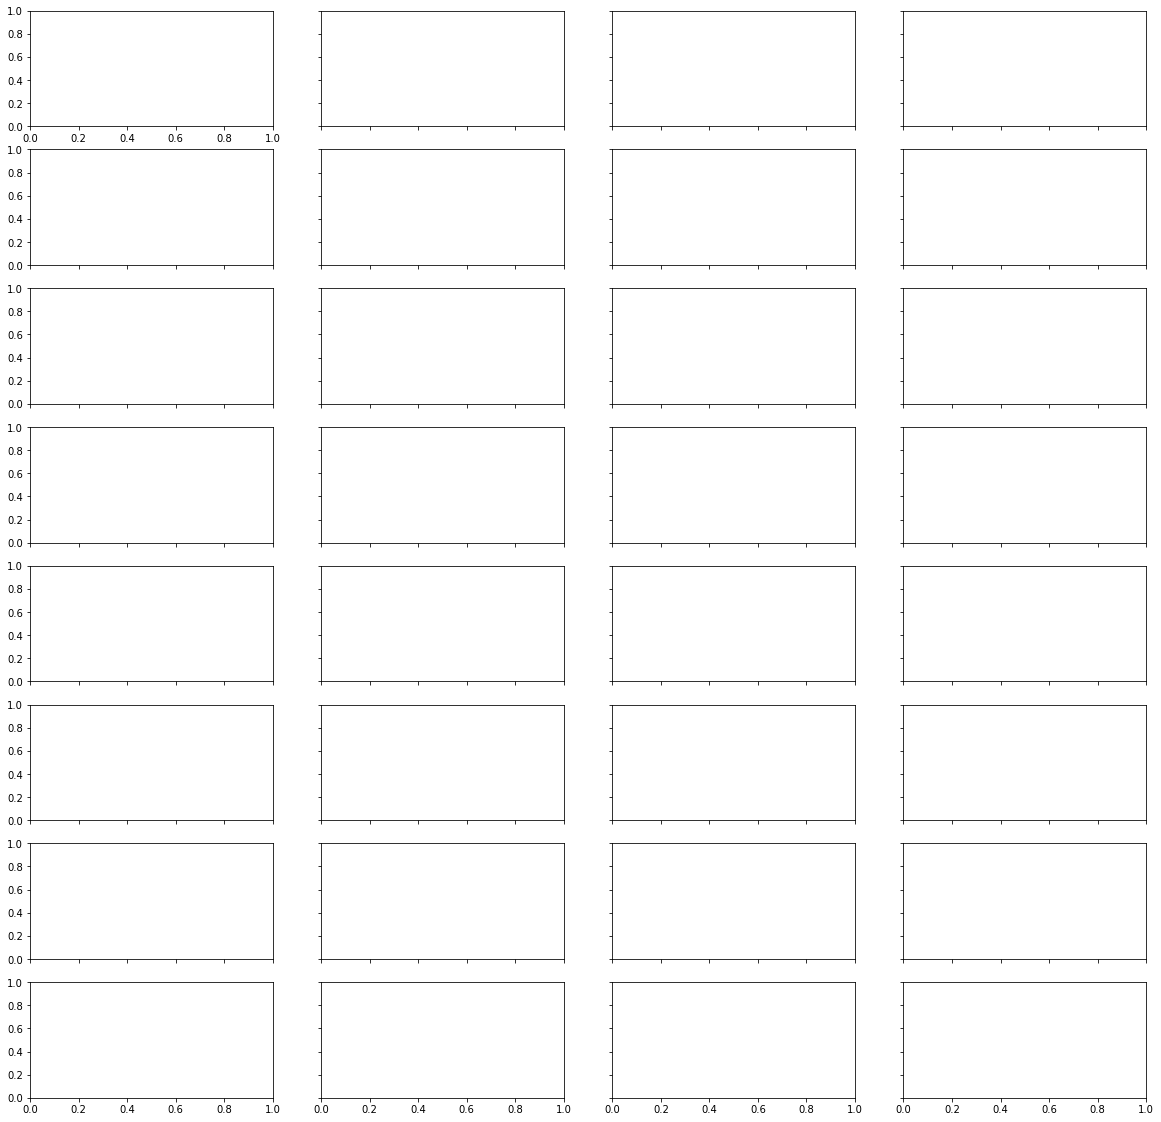

In [222]:
fig, axarr = plt.subplots(8, 4, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(4):
    plt.subplot(8, 4, c+1)
    plt.imshow(debug_layers['fpn_lidar'][3][0, :, :, c])
    c += 1
plt.show()

In [223]:
res_groups[1].shape

(1, 128, 112, 128)

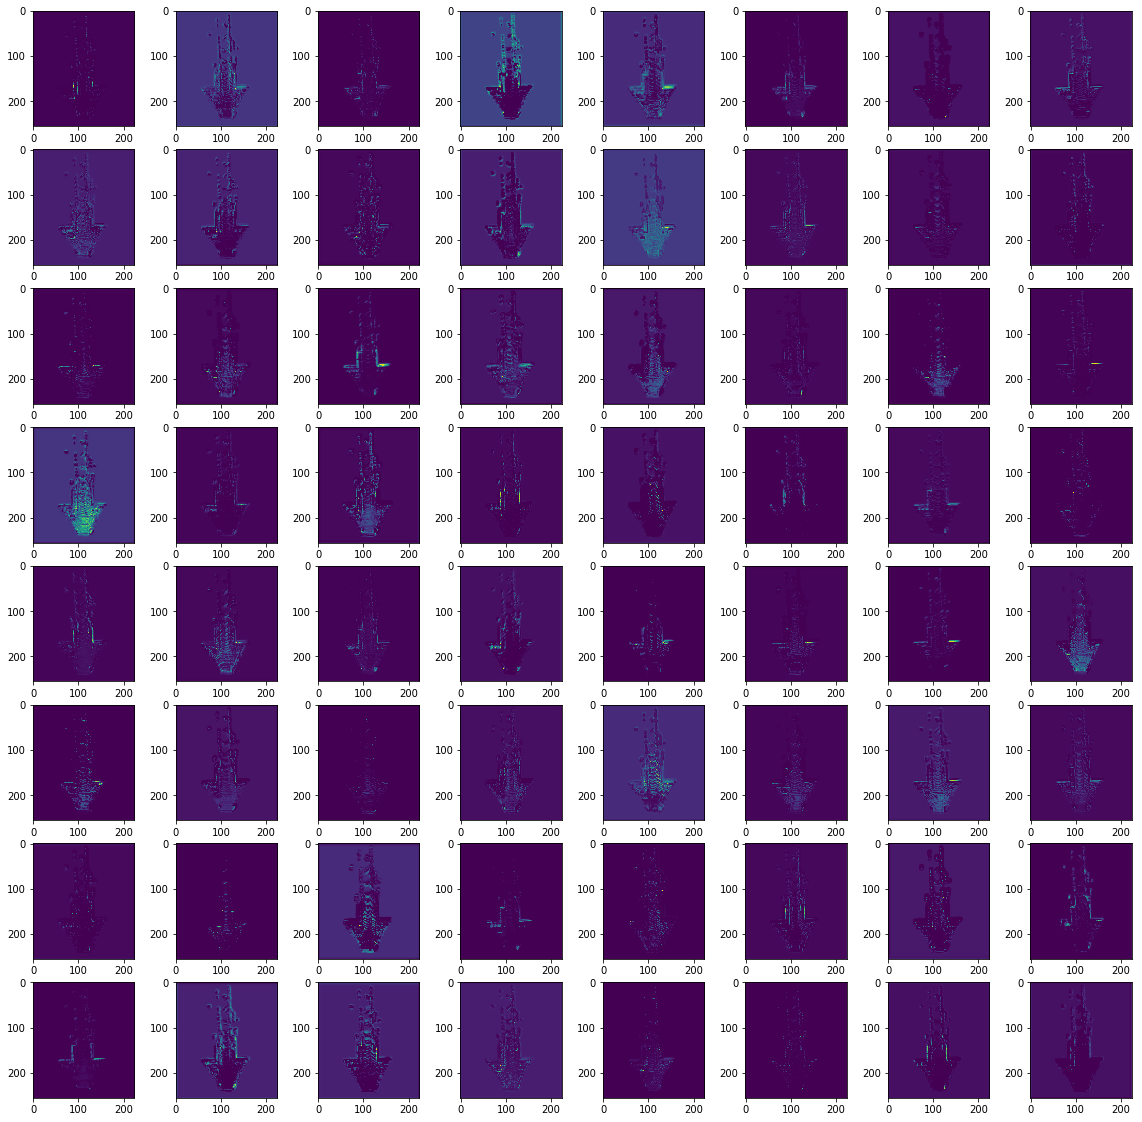

In [224]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups[0][0, :, :, c])
    c += 1
plt.show()

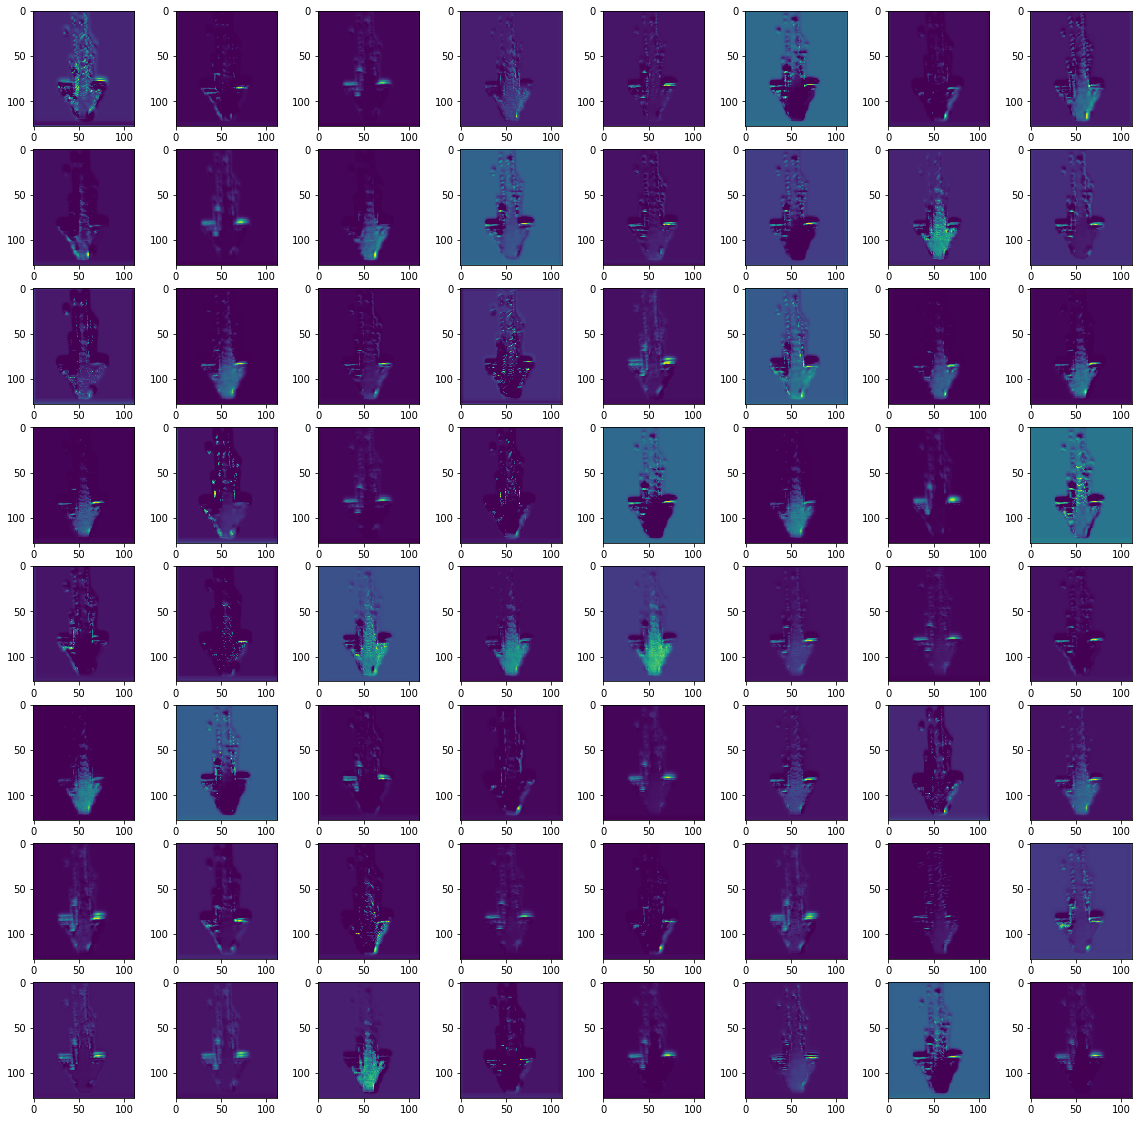

In [225]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups[1][0, :, :, c])
    c += 1
plt.show()

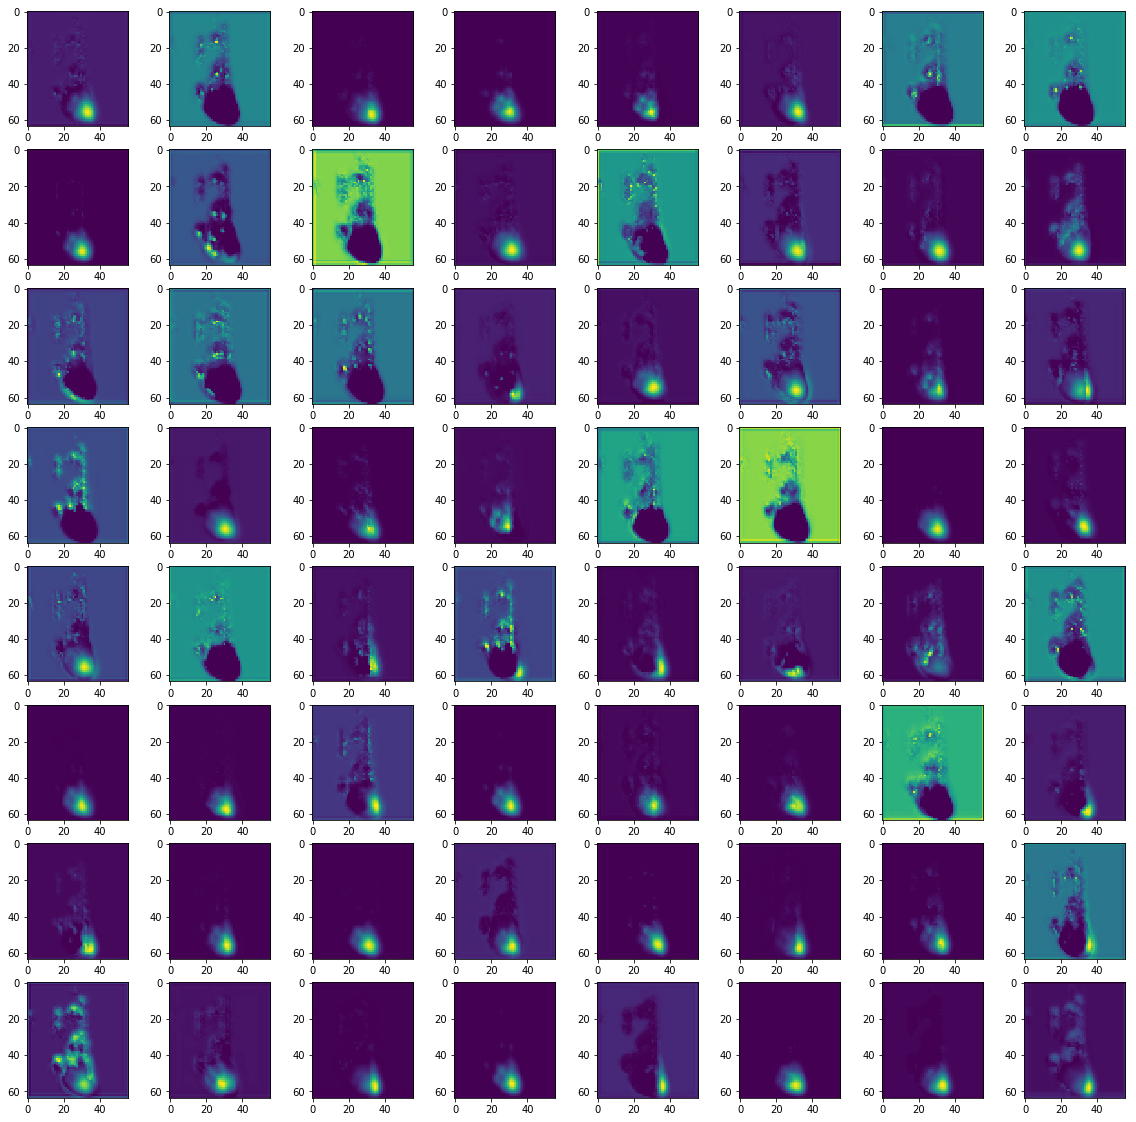

In [321]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups[2][0, :, :, c])
    c += 1
plt.show()

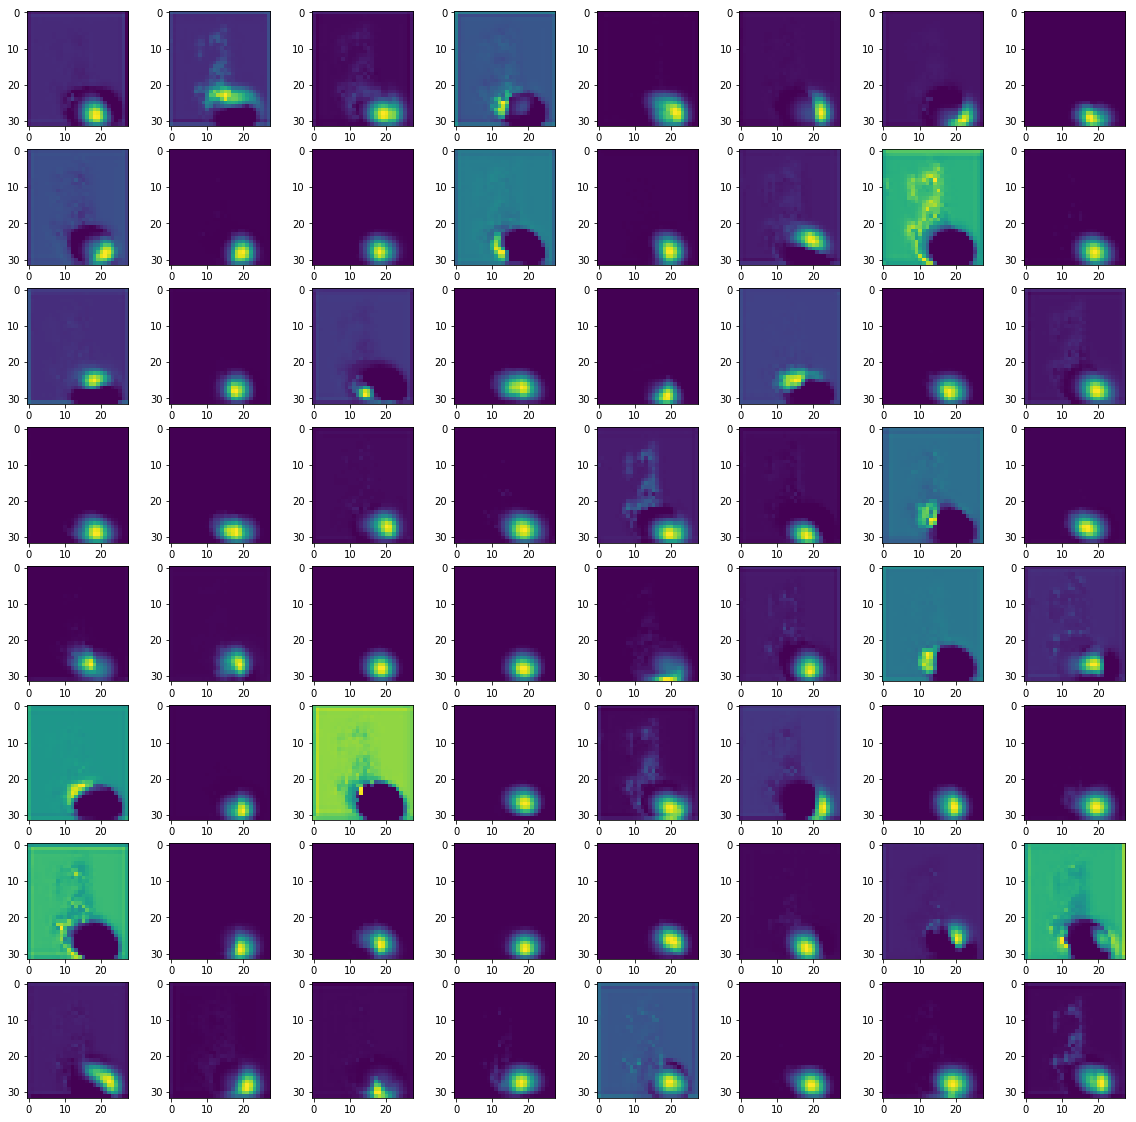

In [322]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(res_groups[3][0, :, :, c])
    c += 1
plt.show()

In [780]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_0'][0, :, :, c])
#     c += 1
# plt.show()

In [102]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_1'][0, :, :, c])
#     c += 1
# plt.show()

In [67]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_2'][0, :, :, c])
#     c += 1
# plt.show()

In [ ]:
# fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
# fig.set_figwidth(20)
# fig.set_figheight(20)
# c = 0
# for i in range(8):
#   for j in range(8):
#     plt.subplot(8, 8, c+1)
#     plt.imshow(debug_layers['fpn_lidar_output_post_conv_3'][0, :, :, c])
#     c += 1
# plt.show()

In [13]:
# with model.graph.as_default():
                
#             config = tf.ConfigProto()
#             config.gpu_options.allow_growth = True

#             with tf.Session(config=config) as sess:
#                 model.saver.restore(sess, tf.train.latest_checkpoint('../tmp/'))

#                 for epoch in range(1):
#                     print('Start epoch {0}'.format(1))

#                     dataset = make_dataset_img('../../../Data', batch_size=1, num_samples=None, training_per=0.8, random_seed=0, training=False)

#                     while True:
#                             images = []
#                             labels = []
#                             for _ in range(1):
#                                 image, label = list(next(dataset))
#                                 images.extend(image)
#                                 labels.extend(label)

#                             images = np.array(images)
#                             labels = np.array(labels)

#                             loss, summary, acc, detection_layer = sess.run([model.model_loss_img, 
#                                                            model.merged_img_seg, model.accuracy, model.detection_layer], 
#                                                     feed_dict={model.train_inputs_rgb: images, 
#                                                                model.y_true_img: labels})
#                             break

In [43]:
detection_layer.shape

(1, 24, 78, 1)

In [260]:
# plt.imshow(images[0])

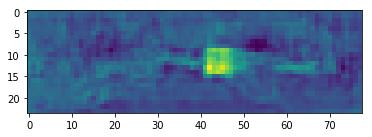

In [19]:
plt.imshow(detection_layer[0, :, :, 0])

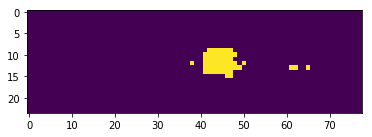

In [20]:
plt.imshow(sigmoid(detection_layer[0, :, :, 0])>=0.5)

In [21]:
np.max(feed_dict[model.train_inputs_rgb][0])

1.0

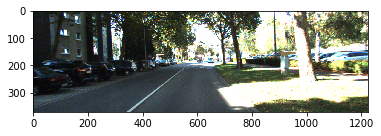

In [258]:
plt.imshow(feed_dict[model.train_inputs_rgb][0])

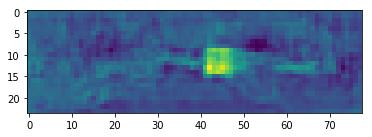

In [23]:
plt.imshow(detection_layer[0, :, :, 0])

In [16]:
plt.imshow(sigmoid(detection_layer[0, :, :, 0])>=0.5)

NameError: name 'detection_layer' is not defined

In [43]:
debug_layers.keys()

dict_keys(['fpn_lidar_output', 'attention_output', 'attention_module_output', 'final_layer', 'fpn_lidar'])

In [264]:
print(regression_loss, classification_loss, loss)

1.1920939e-05 0.0011203992 0.0011323201


In [265]:
#fusion
print(regression_loss, classification_loss, loss)

1.1920939e-05 0.0011203992 0.0011323201


In [14]:
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)
ln = int(len(list_files) * 0.8)
list_files= list_files[ln:]

In [15]:
current_file = list_files[i_c]
current_file

'004327'

In [421]:
!cat ../../../Data/data_object_label_2/training/label_2/005053.txt

Car 0.00 0 -1.57 560.60 177.75 608.40 221.32 1.60 1.76 3.84 -0.95 1.32 28.61 -1.60
Car 0.71 0 -0.86 0.00 178.16 150.82 325.66 1.66 1.62 3.95 -7.70 1.58 8.78 -1.57
Car 0.00 0 -1.31 305.12 178.57 485.23 300.53 1.64 1.72 4.24 -3.29 1.55 11.89 -1.57
Car 0.00 1 -1.18 229.76 185.69 353.27 248.92 1.45 1.61 3.72 -8.15 1.48 18.81 -1.58
Car 0.00 1 -1.00 43.35 183.92 207.60 248.15 1.51 1.66 4.13 -12.79 1.49 19.36 -1.58
Car 0.00 1 -1.41 459.29 181.93 522.95 227.18 1.48 1.64 3.81 -4.12 1.37 25.71 -1.57
Car 0.00 1 -1.46 509.10 182.89 548.63 211.10 1.37 1.61 4.21 -4.11 1.26 37.80 -1.57
Van 0.00 1 -1.53 535.02 166.27 559.01 195.58 2.74 2.09 5.96 -5.91 0.95 70.68 -1.62
Car 0.00 2 -1.14 216.87 182.97 310.86 228.04 1.50 1.55 3.99 -12.52 1.43 26.38 -1.58


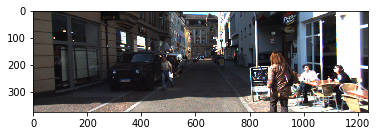

In [16]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [17]:
all_data, label, Tr_velo_to_cam, R0_rect, P3 = read_label(base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

lidar_image = velo_points_bev(base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin', 
                           size=(512, 448, 32))

In [18]:
len(label)

2

In [20]:
lidar_image.shape

(512, 448, 32)

In [21]:
lidar_image.transpose().shape

(32, 448, 512)

<Figure size 432x288 with 0 Axes>

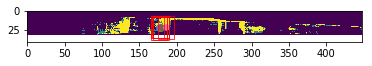

In [18]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5]
    h = label[i][4] 
    d = label[i][3]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(x, y, z)
#     print(w, h, d)
#     print()
    plt.scatter(y, z, s=30)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958)
    
    rect = patches.Rectangle((y-w/2, z-d/2),w, d, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
#     break

plt.show()


22.051029565760565 11.431129686668799 175.89810599999998
19.61183862606388 12.738002823409738 0.5729580000000132
21.569982901954496 11.945524752269673 178.762896
23.741895206272893 11.591579678063477 147.823164
14.438560631329551 10.843864360542392 153.55274400000002
21.873347694466418 12.22315673990359 159.855282
22.018551684268864 8.606620676614414 91.67328


<Figure size 432x288 with 0 Axes>

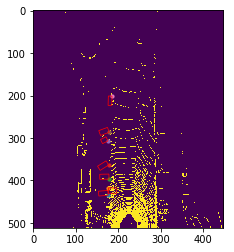

In [25]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    plt.scatter(y, x, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    print(w, h, a*57.2958)
    
    rect = patches.Rectangle((y, x),w, h, angle= a*57.2958*1,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
#     break

plt.show()


<Figure size 432x288 with 0 Axes>

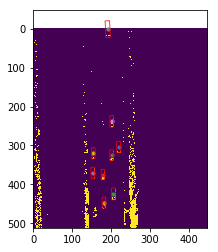

In [25]:



plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, 13:], 2), 0, 1)
ax.imshow(img)

boxes = []

for j in range(0, len(label)):

    w = label[j][5]
    h = label[j][4] 
    x = label[j][0]
    y = label[j][1]
    a = label[j][6]
    if a < 0:
          a = a + 3.14
#     print(w, h, a*57.2958)
    
    plt.scatter(y, x, s=10)

    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])
        
    boxes.append([xs[0], ys[0], xs[2], ys[2]])
#     if j == 0:
#         boxes.append([xs[0]+5, ys[0]+10, xs[2]+5, ys[2]+10])
    
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
#     l = []
#     for i in range(4):
#         l.append([xs[i]+5, ys[i]+10])
    
#     rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
        
plt.show()

In [31]:
boxes = np.array(boxes)
boxes.shape

(10, 4)

In [40]:
selected_indices = tf.image.non_max_suppression(
    boxes, np.ones((10)), max_output_size=30, iou_threshold=0.1)
selected_boxes = tf.gather(boxes, selected_indices)
with tf.Session() as sess:
    print(sess.run(selected_indices))

[0 2 6 9 8 5 7 4 3]


<tf.Tensor 'GatherV2:0' shape=(?, 4) dtype=float64>

In [48]:
temp1 = np.where(sigmoid(final_output[0, :, :, :, -1]) >=0.5)
temp1[0].shape

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


(3,)

In [24]:
temp1 = np.where(sigmoid(feed_dict[model.y_true][0, :, :, :, -1]) >0.5)
temp1[0].shape

(9,)

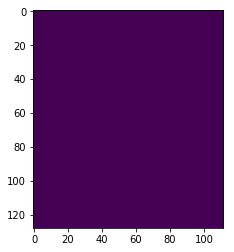

In [19]:
plt.imshow(feed_dict[model.y_true][0, :, :, 0, -2])
plt.show()

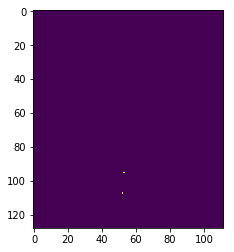

In [20]:
plt.imshow(feed_dict[model.y_true][0, :, :, 1, -2])
plt.show()

In [336]:
np.min(final_output[0, :, :, :, -2])

-18.18268

In [337]:
np.max(final_output[0, :, :, :, -2])

1.0977685

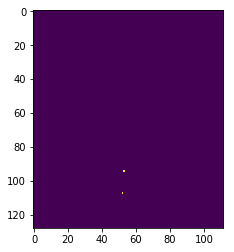

In [29]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -2]) >= 0.4)
plt.show()

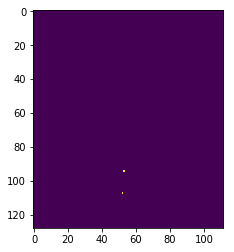

In [30]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1]) < 0.6)
plt.show()

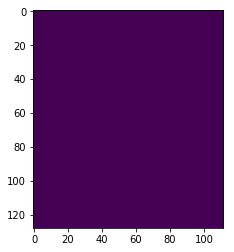

In [343]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1]) < 0.6)
plt.show()

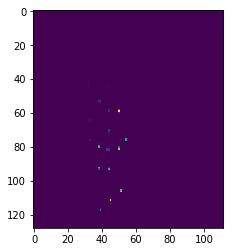

In [344]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -2]))
plt.show()

In [345]:
np.max(sigmoid(final_output[0, :, :, 1, -2]))

0.74984175

In [346]:
np.min(sigmoid(final_output[0, :, :, 1, -1]))

0.30835772

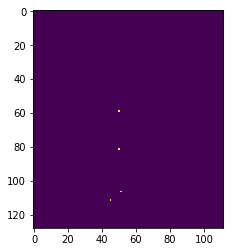

In [347]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1])<0.5)
plt.show()

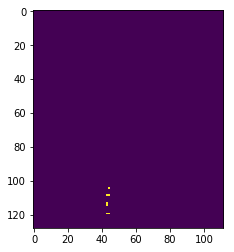

In [220]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1])<0.9)
plt.show()

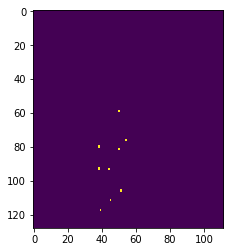

In [168]:
plt.imshow((sigmoid(final_output[0, :, :, 1, -2]) >= 0.5))
plt.show()

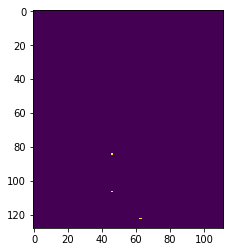

In [274]:
plt.imshow((sigmoid(final_output[0, :, :, 0, -2]) >= 0.1) & (sigmoid(final_output[0, :, :, 0, -1])<0.9))
plt.show()

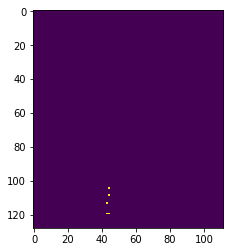

In [223]:
plt.imshow((sigmoid(final_output[0, :, :, 0, -2]) >= 0.1) & (sigmoid(final_output[0, :, :, 0, -1])<0.8))
plt.show()

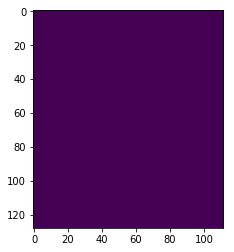

In [106]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -2]) >= 0.1)
plt.show()

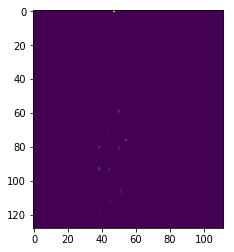

In [144]:
plt.imshow(cls_loss_out[0])

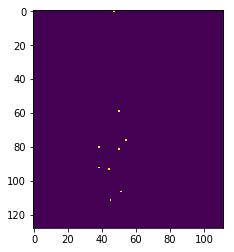

In [59]:
plt.imshow(cls_loss_out[0]>0.5)

In [60]:
np.max(cls_loss_out[0])

6.2180543

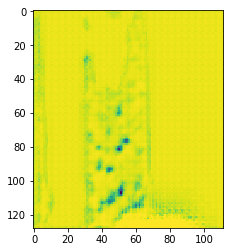

In [61]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1]))
plt.show()

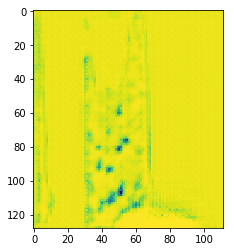

In [62]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -1]))
plt.show()

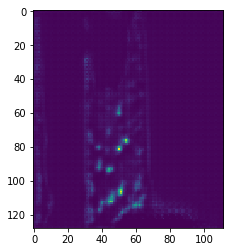

In [63]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -2]))
plt.show()

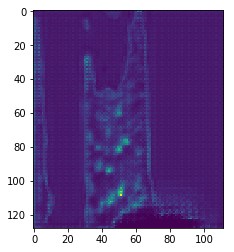

In [64]:
plt.imshow(sigmoid(final_output[0, :, :, 0, -2]))
plt.show()

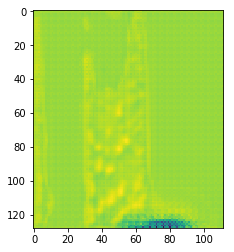

In [65]:
plt.imshow(final_output[0, :, :, 1, -2])
plt.show()

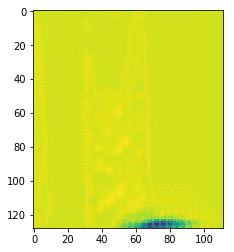

In [66]:
plt.imshow(final_output[0, :, :, 0, -2])
plt.show()

In [59]:
th=0.01

In [60]:
from data.postprocessing.nms import *

In [61]:
def get_points(converted_points, calib_path, 
                x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                size=(512, 448, 32), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[7]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8:11] = converted_points_[3:6]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[7])

            calib_data = read_calib(calib_path)

            # x_range=(0, 70)
            # y_range=(-40, 40)
            # z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[3], converted_points_[4],
                         converted_points_[5], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

In [62]:
converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

print('\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))]))

Car -1 -1 -10 540 179 562 195 1.5176524 1.6225553 3.926147 -5.428357402278281 0.9712897323575364 69.92848311485024 1.6402054 0.01276772
Car -1 -1 -10 316 181 364 206 1.5351748 1.5905745 3.8880644 -16.891472492659585 1.3074785716086712 45.577306063890624 1.5669429 0.0113201775
Car -1 -1 -10 325 182 378 204 1.3343135 1.6003128 3.737116 -16.1768569881858 1.1646278967236627 45.57597035986237 1.7393944 0.012129245
Car -1 -1 -10 280 182 343 209 1.4451118 1.7012599 3.7532125 -16.178897403833545 1.2783807362848831 39.463129339918964 1.646879 0.011869071
Car -1 -1 -10 510 181 551 211 1.528496 1.6077448 4.019378 -4.009345345439038 1.3200222248393898 37.79086240366816 1.613413 0.022348726
Car -1 -1 -10 518 177 570 207 1.4853828 1.7275035 4.303529 -3.295157773855472 1.1076906968330218 37.78902586911894 1.7261686 0.010011467
Car -1 -1 -10 513 181 546 212 1.5216092 1.5027716 3.8240361 -4.00941473634168 1.3448463851253971 37.235253968194264 1.510507 0.027286638
Car -1 -1 -10 518 179 568 209 1.4693365

In [63]:
len(converted_points)

130

In [64]:
len(points)

130

In [65]:
# res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
# _, labels, _, _, _ = read_label(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
# selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.1)
# print(selected_idx)
# points = np.array(points)
# points = points[selected_idx]

In [66]:
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

In [67]:
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
text_file = open('./' + current_file + '_fusion.txt', "wb+")
text_file.write(res.encode())
text_file.close()

In [68]:
all_data, label_bev, Tr_velo_to_cam, R0_rect, P3 = read_label('./'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

In [69]:
all_data, label_fusion, Tr_velo_to_cam, R0_rect, P3 = read_label('./'+ current_file + '_fusion.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

<Figure size 432x288 with 0 Axes>

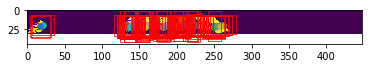

In [70]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label_fusion)):
    w = label_fusion[i][5]
    h = label_fusion[i][4] 
    d = label_fusion[i][3]
    x = label_fusion[i][0]
    y = label_fusion[i][1]
    z = label_fusion[i][2]
#     print(x, y, z)
#     print(w, h, d)
#     print()
    plt.scatter(y, z, s=30)
    a = label_fusion[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958)
    
    rect = patches.Rectangle((y-w/2, z-d/2),w, d, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
#     break

plt.show()


<Figure size 432x288 with 0 Axes>

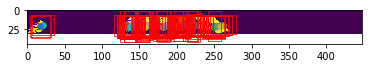

In [71]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label_bev)):
    w = label_bev[i][5]
    h = label_bev[i][4] 
    d = label_bev[i][3]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(x, y, z)
#     print(w, h, d)
#     print()
    plt.scatter(y, z, s=30)
    a = label_bev[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958)
    
    rect = patches.Rectangle((y-w/2, z-d/2),w, d, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
#     break

plt.show()


<Figure size 432x288 with 0 Axes>

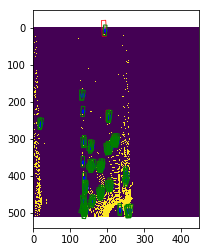

In [72]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    plt.scatter(y, x, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][5] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    plt.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=1.,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

print()
    
# for i in range(0, len(label_fusion)):
#     w = label_fusion[i][5] 
#     h = label_fusion[i][4] 
#     x = label_fusion[i][0]
#     y = label_fusion[i][1]
# #     print(w, h, label_fusion[i][6]*57.2958)
#     plt.scatter(y, x, s=10)

#     polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
#     xs = polygon[0::2]
#     ys = polygon[1::2]
#     l = []
#     for i in range(4):
#         l.append([xs[i], ys[i]])

#     rect = patches.Polygon(l,linewidth=0.5,edgecolor='w',facecolor='none')
#     ax.add_patch(rect)


plt.show()


27.631674362194403 9.83650621419092 -91.67328
28.428133306988247 9.051454818463926 -89.954406
30.51526208142533 9.610186597381494 -89.954406
26.77234106642759 8.99585101638743 -90.527364
29.72305607643701 9.275225271554694 -90.527364
27.420553898639287 9.163201174247444 -89.954406
30.29935220820766 8.995581640572137 -89.954406
42.87319419846623 11.686928827817722 -92.819196
28.71549485350705 8.660601910186665 -90.527364


<Figure size 432x288 with 0 Axes>

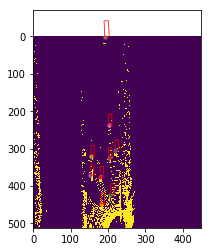

In [73]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    print(w, h, label[i][6]*57.2958)
    plt.scatter(y, x, s=10)

    rect = patches.Rectangle((y, x),w, h, angle= label[i][6]*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

plt.show()


22.051029565760565 11.431129686668799 175.89810599999998
19.61183862606388 12.738002823409738 -179.33585399999998
21.569982901954496 11.945524752269673 178.762896
23.741895206272893 11.591579678063477 147.823164
14.438560631329551 10.843864360542392 153.55274400000002
21.873347694466418 12.22315673990359 159.855282
22.018551684268864 8.606620676614414 91.67328


<Figure size 432x288 with 0 Axes>

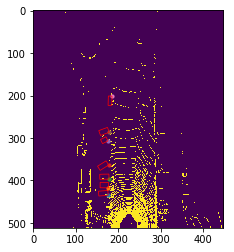

In [326]:
#fusion
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 9:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][5] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    print(w, h, label[i][6]*57.2958)
    plt.scatter(y, x, s=10)

    rect = patches.Rectangle((y, x),w, h, angle= label[i][6]*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

plt.show()


In [32]:
debug_layers.keys()

dict_keys(['fpn_lidar_res_1', 'fpn_lidar_res_3', 'fpn_lidar', 'final_layer', 'fpn_lidar_output', 'fpn_lidar_res_2', 'fpn_lidar_res_0', 'attention_module_output', 'attention_output'])

In [33]:
debug_layers['attention_output'].shape

(1, 32, 28, 64)

In [34]:
debug_layers['attention_module_output'].shape

(1, 32, 28, 256)

In [50]:
debug_layers['fpn_lidar_output'][0].shape

(128, 112, 128)

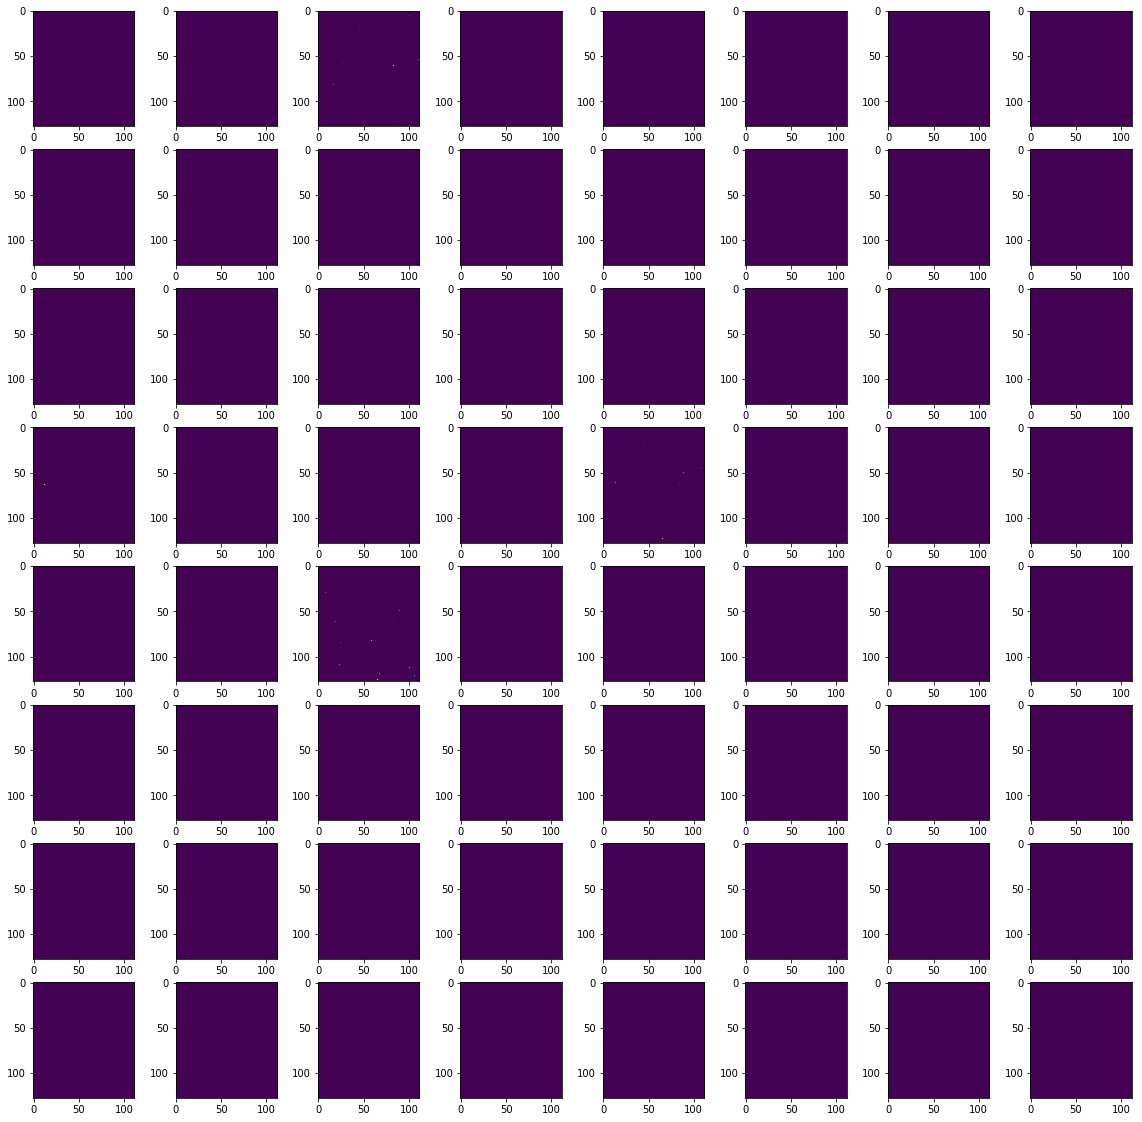

In [51]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['fpn_lidar_output'][0][:, :, c])
    c += 1
plt.show()

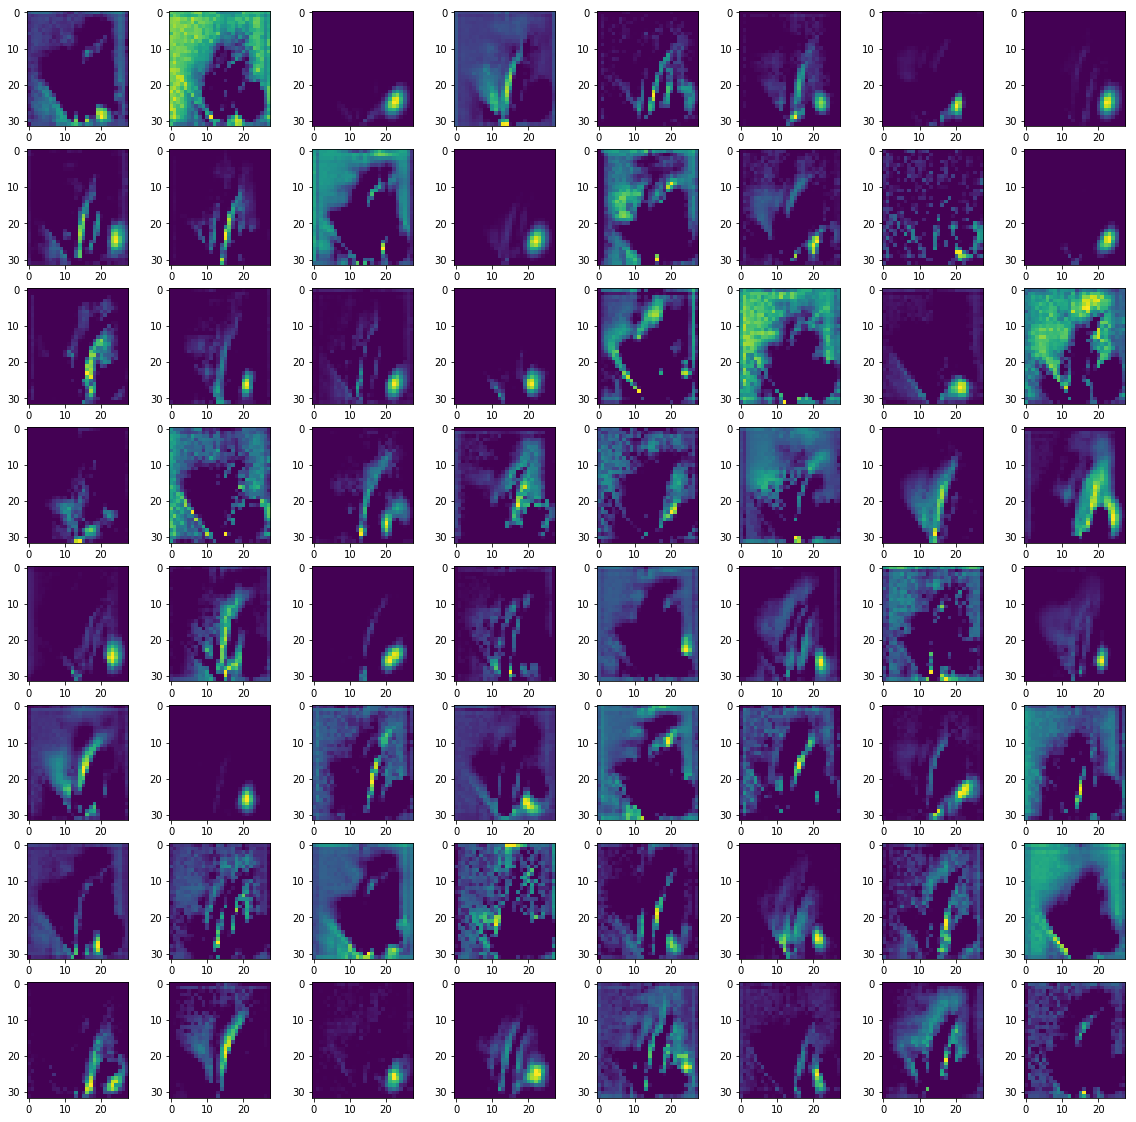

In [101]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['attention_module_output'][0, :, :,0+c])
    c += 1
plt.show()

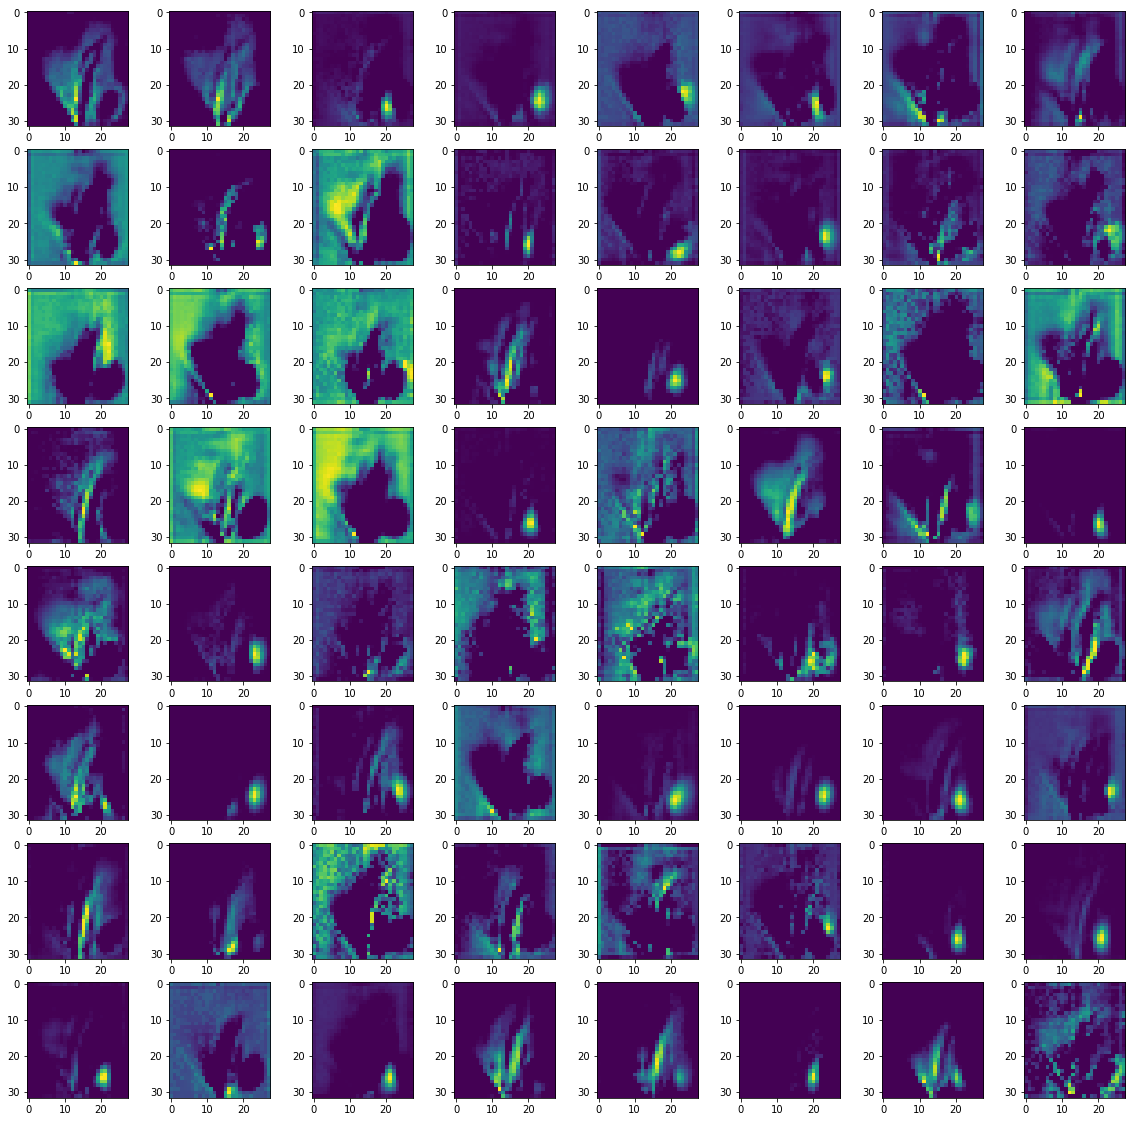

In [102]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['attention_module_output'][0, :, :,64+c])
    c += 1
plt.show()

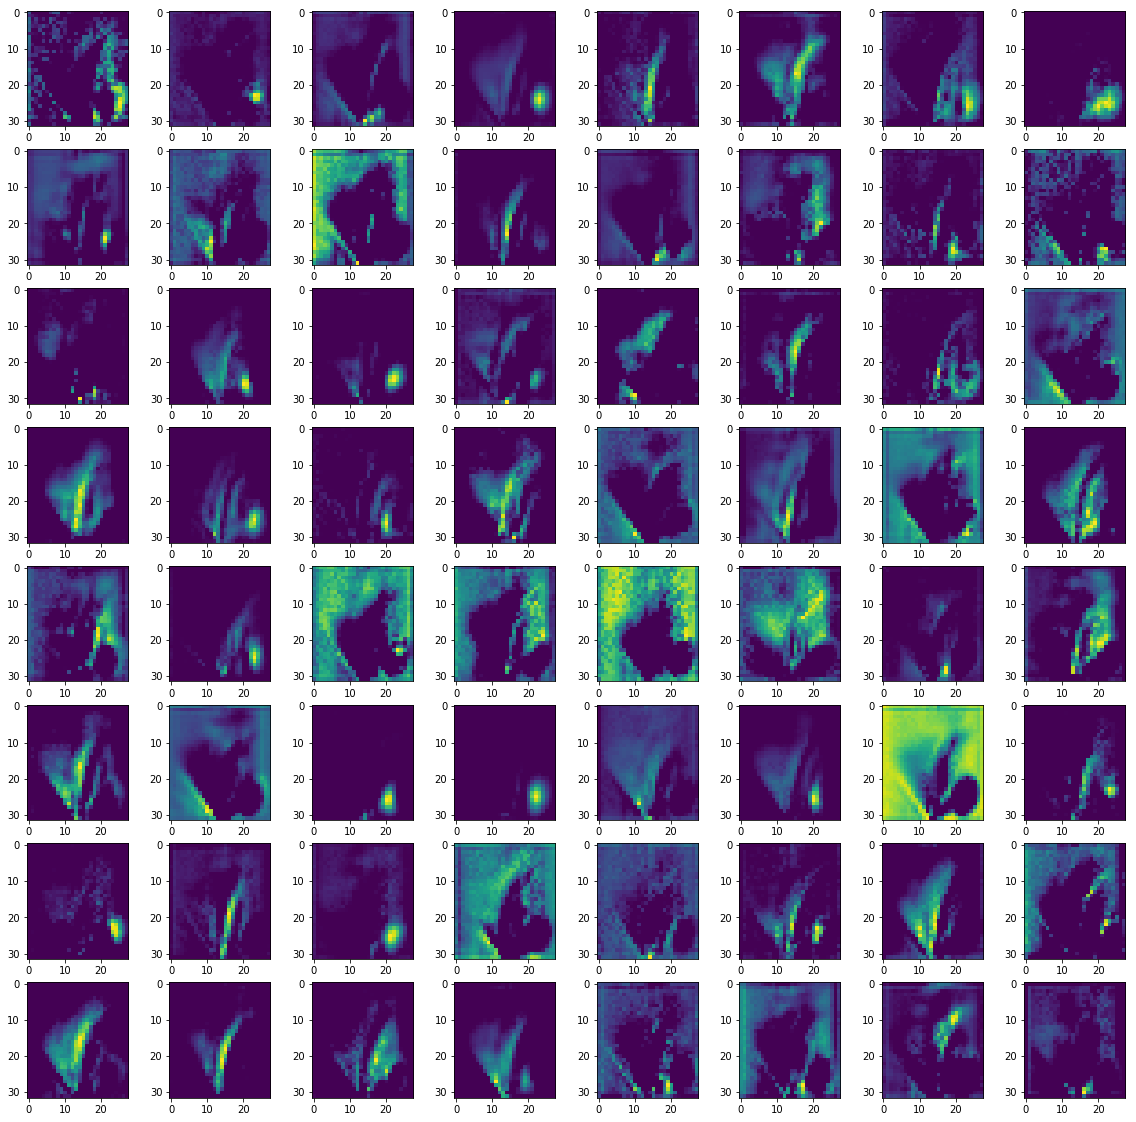

In [103]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['attention_module_output'][0, :, :,128+c])
    c += 1
plt.show()

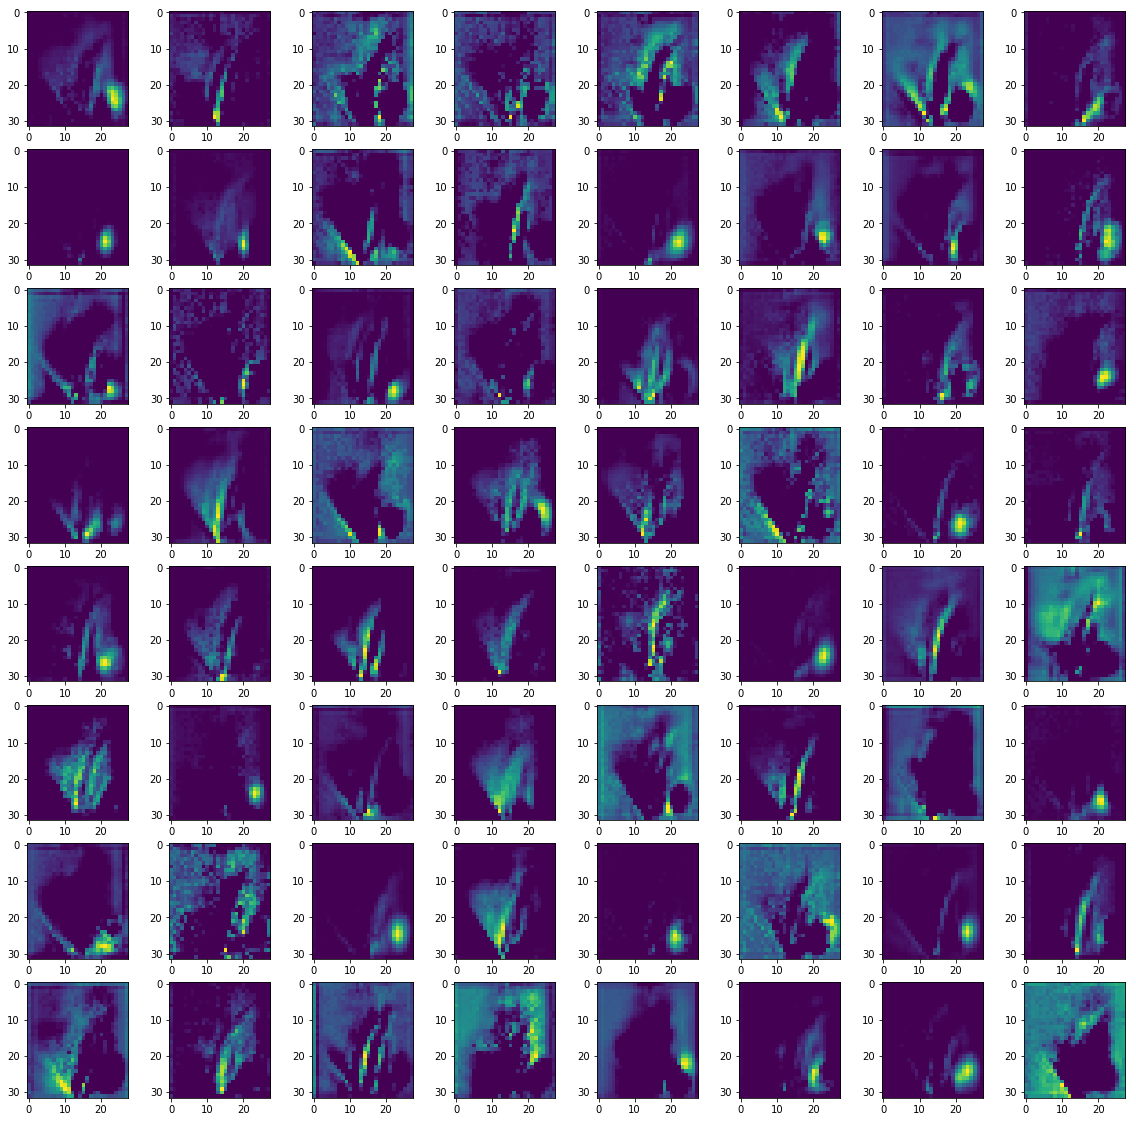

In [104]:
fig, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 0
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, c+1)
    plt.imshow(debug_layers['attention_module_output'][0, :, :,192+c])
    c += 1
plt.show()

In [100]:
def write_predictions(final_output, th, new_file_path, old_file_path, apply_nms=False, sess=None):
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    
    res = []
    with open(old_file_path) as label_file:
            res = label_file.readlines()
    res = ''.join(res)
    points2 = res.split('\n')
    points = []
    for i in range(len(points2)):
        temp = []
        temp = points2[i].split(' ')
        points.append(temp)
#     print(points.split('\n')[0])
    
#     converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
#     points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)
#     print(len(points))
#     res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#     with tf.device('/device:CPU:0'):
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    if apply_nms:
            labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
            if len(labels) != len(points):
                print('not the same', new_file_path, len(labels), len(points))
    #             return
            points = np.array(points)
            
            if len(labels) > 0:
                points = points[indxes]
                selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3, sess=sess)
            else:
                selected_idx = []

            if len(selected_idx) > 0:
                points = points[selected_idx]
                res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
            else:
                res=""
#     now = datetime.now()
#     current_time = now.strftime("%H:%M:%S")
#     print("Current Time =", current_time)
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

In [101]:
base_path = '../../../Data'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)
ln = int(len(list_files) * 0.5)
list_files= list_files[ln:]

In [102]:
dir_name = 'predictions_focal_model_new_12_nms'

In [103]:
!rm -r "../prediction_files/""$dir_name"

rm: cannot remove '../prediction_files/predictions_focal_model_new_12_nms': No such file or directory


In [104]:
!mkdir "../prediction_files/""$dir_name"
!mkdir "../prediction_files/""$dir_name""/bev/"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2/data"

In [110]:
if True:
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp_best2/'))

#     anchor_values = prepare_anchors()
#     anchor_values = np.repeat(anchor_values, 1, axis=0)
#     dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=False)
   
    cls_losses = []
    reg_losses = []
    total_losses = []
    i = 1480
    
    apply_nms=True
    
    try:    
        while True:
#             feed_dict = prepare_dataset_feed_dict(model, dataset, False, False, anchor_values, False)

#             final_output= sess.run(model.final_output, feed_dict=feed_dict)
            final_output = None
            if i < len(list_files):
                current_file = list_files[i]
                old_file_path = '../prediction_files/' + 'predictions_focal_model_new_12' + '/bev/th10_2/data/' + current_file + '.txt'
                th = 0.10
                new_file_path = '../prediction_files/' + dir_name + '/bev/th10_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                old_file_path = '../prediction_files/' + 'predictions_focal_model_new_12' + '/bev/th10_2/data/' + current_file + '.txt'
                th = 0.20
                new_file_path = '../prediction_files/' + dir_name + '/bev/th20_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, old_file_path, apply_nms=apply_nms, sess=sess)
                
                old_file_path = '../prediction_files/' + 'predictions_focal_model_new_12' + '/bev/th30_2/data/' + current_file + '.txt'
                th = 0.30
                new_file_path = '../prediction_files/' + dir_name + '/bev/th30_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, old_file_path, apply_nms=apply_nms)
                
                old_file_path = '../prediction_files/' + 'predictions_focal_model_new_12' + '/bev/th40_2/data/' + current_file + '.txt'
                th = 0.40
                new_file_path = '../prediction_files/' + dir_name + '/bev/th40_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, old_file_path, apply_nms=apply_nms)
                
                old_file_path = '../prediction_files/' + 'predictions_focal_model_new_12' + '/bev/th50_2/data/' + current_file + '.txt'
                th = 0.50
                new_file_path = '../prediction_files/' + dir_name + '/bev/th50_2/data/' + current_file + '.txt'
                write_predictions(final_output, th, new_file_path, old_file_path, apply_nms=apply_nms)

            else:
                break
            i += 1
            if i % 100 == 0:
                print('i = ', i)
#             break
    except tf.errors.OutOfRangeError:
        pass
    except StopIteration:
        pass

not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/003249.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/003249.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/003617.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/003617.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/003617.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/000398.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/000398.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/000398.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/002500.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/004192.txt 0 1
not the sa

not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/002536.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/002536.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/002536.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/005463.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/005463.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/005463.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/005422.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/005422.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/005422.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/005683.txt 0 1
not the sa

not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/001791.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/005529.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/004056.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th30_2/data/007344.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th40_2/data/007344.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/007344.txt 0 1
not the same ../prediction_files/predictions_focal_model_new_12_nms/bev/th50_2/data/002336.txt 0 1


KeyboardInterrupt: 